In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
import numpy as np
import sklearn.neighbors as skn
from sklearn.linear_model import LinearRegression
import tqdm
from scipy.stats import norm
import json
import pandas as pd
from collections import defaultdict
import pandas as pd

# torch
import torch
import torch_geometric as pyg

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('style.mcstyle')
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# ili
import ili
from ili.dataloaders import NumpyLoader, StaticNumpyLoader
from ili.inference.runner_sbi import SBIRunner
from ili.validation.metrics import PlotSinglePosterior, PosteriorCoverage
from ili.utils import IndependentTruncatedNormal, Uniform, IndependentNormal

from tools.plot_tools import binned_plot

Using device: cpu


In [2]:
mdir = './saved_models'

def r2logm(r):
    # see preprocessing.ipynb for this measurement
    coef = 0.36752
    intercept = -5.30640
    return (np.log10(r)-intercept)/coef

In [3]:
datanames = ['wC50', 'wC100', 'dC50', 'dC100']
runnames = ['base', 'gals_nle', 'summ_nle', 'gnn_npe']
modelnames = ['msig', 'pamico', 'mamp', 'gals_nle', 'summ_nle', 'gnn_npe']
Nfolds=10
folds = np.arange(Nfolds)

datatitles = dict(
    wC50='Wide $50\%$',
    wC100='Wide $100\%$',
    dC50='Deep $50\%$',
    dC100='Deep $100\%$'
)
modeltitles = dict(
    msig='$M-\sigma$',
    pamico='$M-\lambda_{\\rm AMICO}$',
    mamp='MAMPOSSt',
    gals_nle='Galaxy-Net',
    summ_nle='Summary-Net',
    gnn_npe='Graph-Net'
)

## Check suite

In [4]:
to_count = ['posterior.pkl', 'msig.npz', 'posterior_samples.npy']

saved_models = os.listdir(mdir)
for d in datanames:
    for m in runnames:
        counter = defaultdict(int)
        for f in folds:
            dirname = f'apr24_{m}_{d}_f{f}'
            filelist = os.listdir(join(mdir, dirname))
            for fn in filelist:
                if fn in to_count:
                    counter[fn] += 1
        print(f'{d} {m}:')
        for fn, c in counter.items():
            print(f'\t{fn}: {c}')
    print()

wC50 base:
	msig.npz: 10
wC50 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC50 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC50 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 9

wC100 base:
	msig.npz: 10
wC100 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC100 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
wC100 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10

dC50 base:
	msig.npz: 10
dC50 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC50 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC50 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10

dC100 base:
	msig.npz: 10
dC100 gals_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC100 summ_nle:
	posterior.pkl: 10
	posterior_samples.npy: 10
dC100 gnn_npe:
	posterior.pkl: 10
	posterior_samples.npy: 10



## Load Everything

In [5]:
# load train/test
header = 'APR24'
datadir = './data/processed'

theta, fold, ids, richs = {}, {}, {}, {}
for d in datanames:
    dirpath = join(datadir, f'{header}{d}')
    print('Loading:', dirpath)
    theta[d] = np.load(join(dirpath, 'theta_batch.npy'))
    fold[d] = np.load(join(dirpath, 'folds_batch.npy'))
    ids[d] = np.load(join(dirpath, 'ids_batch.npy'))
    _s = np.load(join(dirpath, 'x_sum.npy'))
    richs[d] = _s[:,3]

Ndata = {d: len(theta[d]) for d in datanames}
print(Ndata)

Loading: ./data/processed/APR24wC50
Loading: ./data/processed/APR24wC100
Loading: ./data/processed/APR24dC50
Loading: ./data/processed/APR24dC100
{'wC50': 840, 'wC100': 907, 'dC50': 1998, 'dC100': 2014}


In [6]:
Nsamp = 100
preds = defaultdict(dict)
for d in datanames:
    for r in runnames:
        # setup
        if r == 'base':
            preds[d]['msig'] = np.ones((Ndata[d], 2))*np.nan
            preds[d]['pamico'] = np.ones((Ndata[d], 2))*np.nan
        else:
            preds[d][r] = np.empty((Ndata[d], Nsamp, 1))

        # load
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            if r == 'base':
                # Msig
                samplefile = join(mdir, dirname, 'msig.npz')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                place_ids = np.searchsorted(ids[d], s['ids'])
                np.put(preds[d]['msig'][:,0], place_ids, s['pred'])
                np.put(preds[d]['msig'][:,1], place_ids, s['std'])


                # Pamico
                samplefile = join(mdir, dirname, 'Pamico.npz')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                place_ids = np.searchsorted(ids[d], s['ids'])
                np.put(preds[d]['pamico'][:,0], place_ids, s['pred'])
                np.put(preds[d]['pamico'][:,1], place_ids, s['std'])


            else:
                # ML models
                samplefile = join(mdir, dirname, 'posterior_samples.npy')
                if not os.path.exists(samplefile):
                    print(f'Skipping {dirname}')
                    continue
                s = np.load(samplefile)
                s = np.swapaxes(s, 0, 1)
                s = s[:, :Nsamp]  # subsample if necessary
                preds[d][r][fold[d] == f] = s

Skipping apr24_gnn_npe_wC50_f6


In [7]:
# load mamposst
modeldir = './saved_models/mamposst_dC100/'

# load
cols = [
    'id', 'r200best', 'r200low68', 'r200high68', 'r200low95', 'r200high95',
    'r200true', 'zclu', 'prob68', 'prob95', 'Ngal', 'nll'
]
isamp = pd.read_csv(join(modeldir, 'result_MockFS_AMICO_deep100.dat'), 
                    delimiter=' ', skipinitialspace=True, header=None, names=cols)
isamp['id'] = isamp['id'].astype(int)

# convert r200 to logm
for c in isamp.columns:
    if 'r200' not in c:
        continue
    isamp['logm'+c[4:]] = r2logm(isamp[c])

# put in preds
preds['dC100']['mamp'] = np.ones((Ndata['dC100'], 5))*np.nan
place_ids = np.searchsorted(ids['dC100'], isamp['id'].values)
_s = isamp[['logmlow68', 'logmhigh68', 'logmlow95', 'logmhigh95', 'logmbest']].values
preds['dC100']['mamp'][place_ids] = _s

In [8]:
# calculate percentiles from predictions
q = 100*np.array([0.16, 0.84, 0.5])
percs = defaultdict(dict)
for d in datanames:
    for m in modelnames:
        if m == 'msig' or m == 'pamico':
            t_ = preds[d][m]
            percs[d][m] = np.stack([t_[:,0]-t_[:,1], t_[:,0]+t_[:,1], t_[:,0]], axis=1).T
        elif m == 'mamp':
            if m not in preds[d]:
                continue
            t_ = preds[d][m]
            percs[d][m] = np.stack([t_[:,0], t_[:,1], t_[:,-1]], axis=1).T
        else:
            t_ = preds[d][m]
            percs[d][m] = np.percentile(t_, q, axis=1)[...,0]

`preds` is organized by the following...

for base models:
`preds[dataname][modelname] = (Ntest, 2)` (mean, std)

for neural models:
`preds[dataname][modelname] = (Ntest, Nsamp, 1)`

## Check loss

In [9]:
def plot_loss(loss, ax, errs=[0.6, 1], color=None, **kwargs):
    # prepare losses
    L = max([len(x) for x in loss])
    lossnan = np.ones((len(loss), L))*np.nan
    for i, l in enumerate(loss):
        lossnan[i, :len(l)] = l
    
    q = []
    for e in errs:
        q += [0.5-e/2, 0.5+e/2]
    q += [0.5]
    q = np.array(q)*100
    
    x_ = range(L)
    percs = np.nanpercentile(lossnan, q=q, axis=0)
    for i in range(len(errs)):
        ax.fill_between(x_, percs[2*i], percs[2*i+1], alpha=0.2, color=color)
    ax.plot(x_, percs[-1], color=color, **kwargs)

wC50
wC100
dC50
dC100


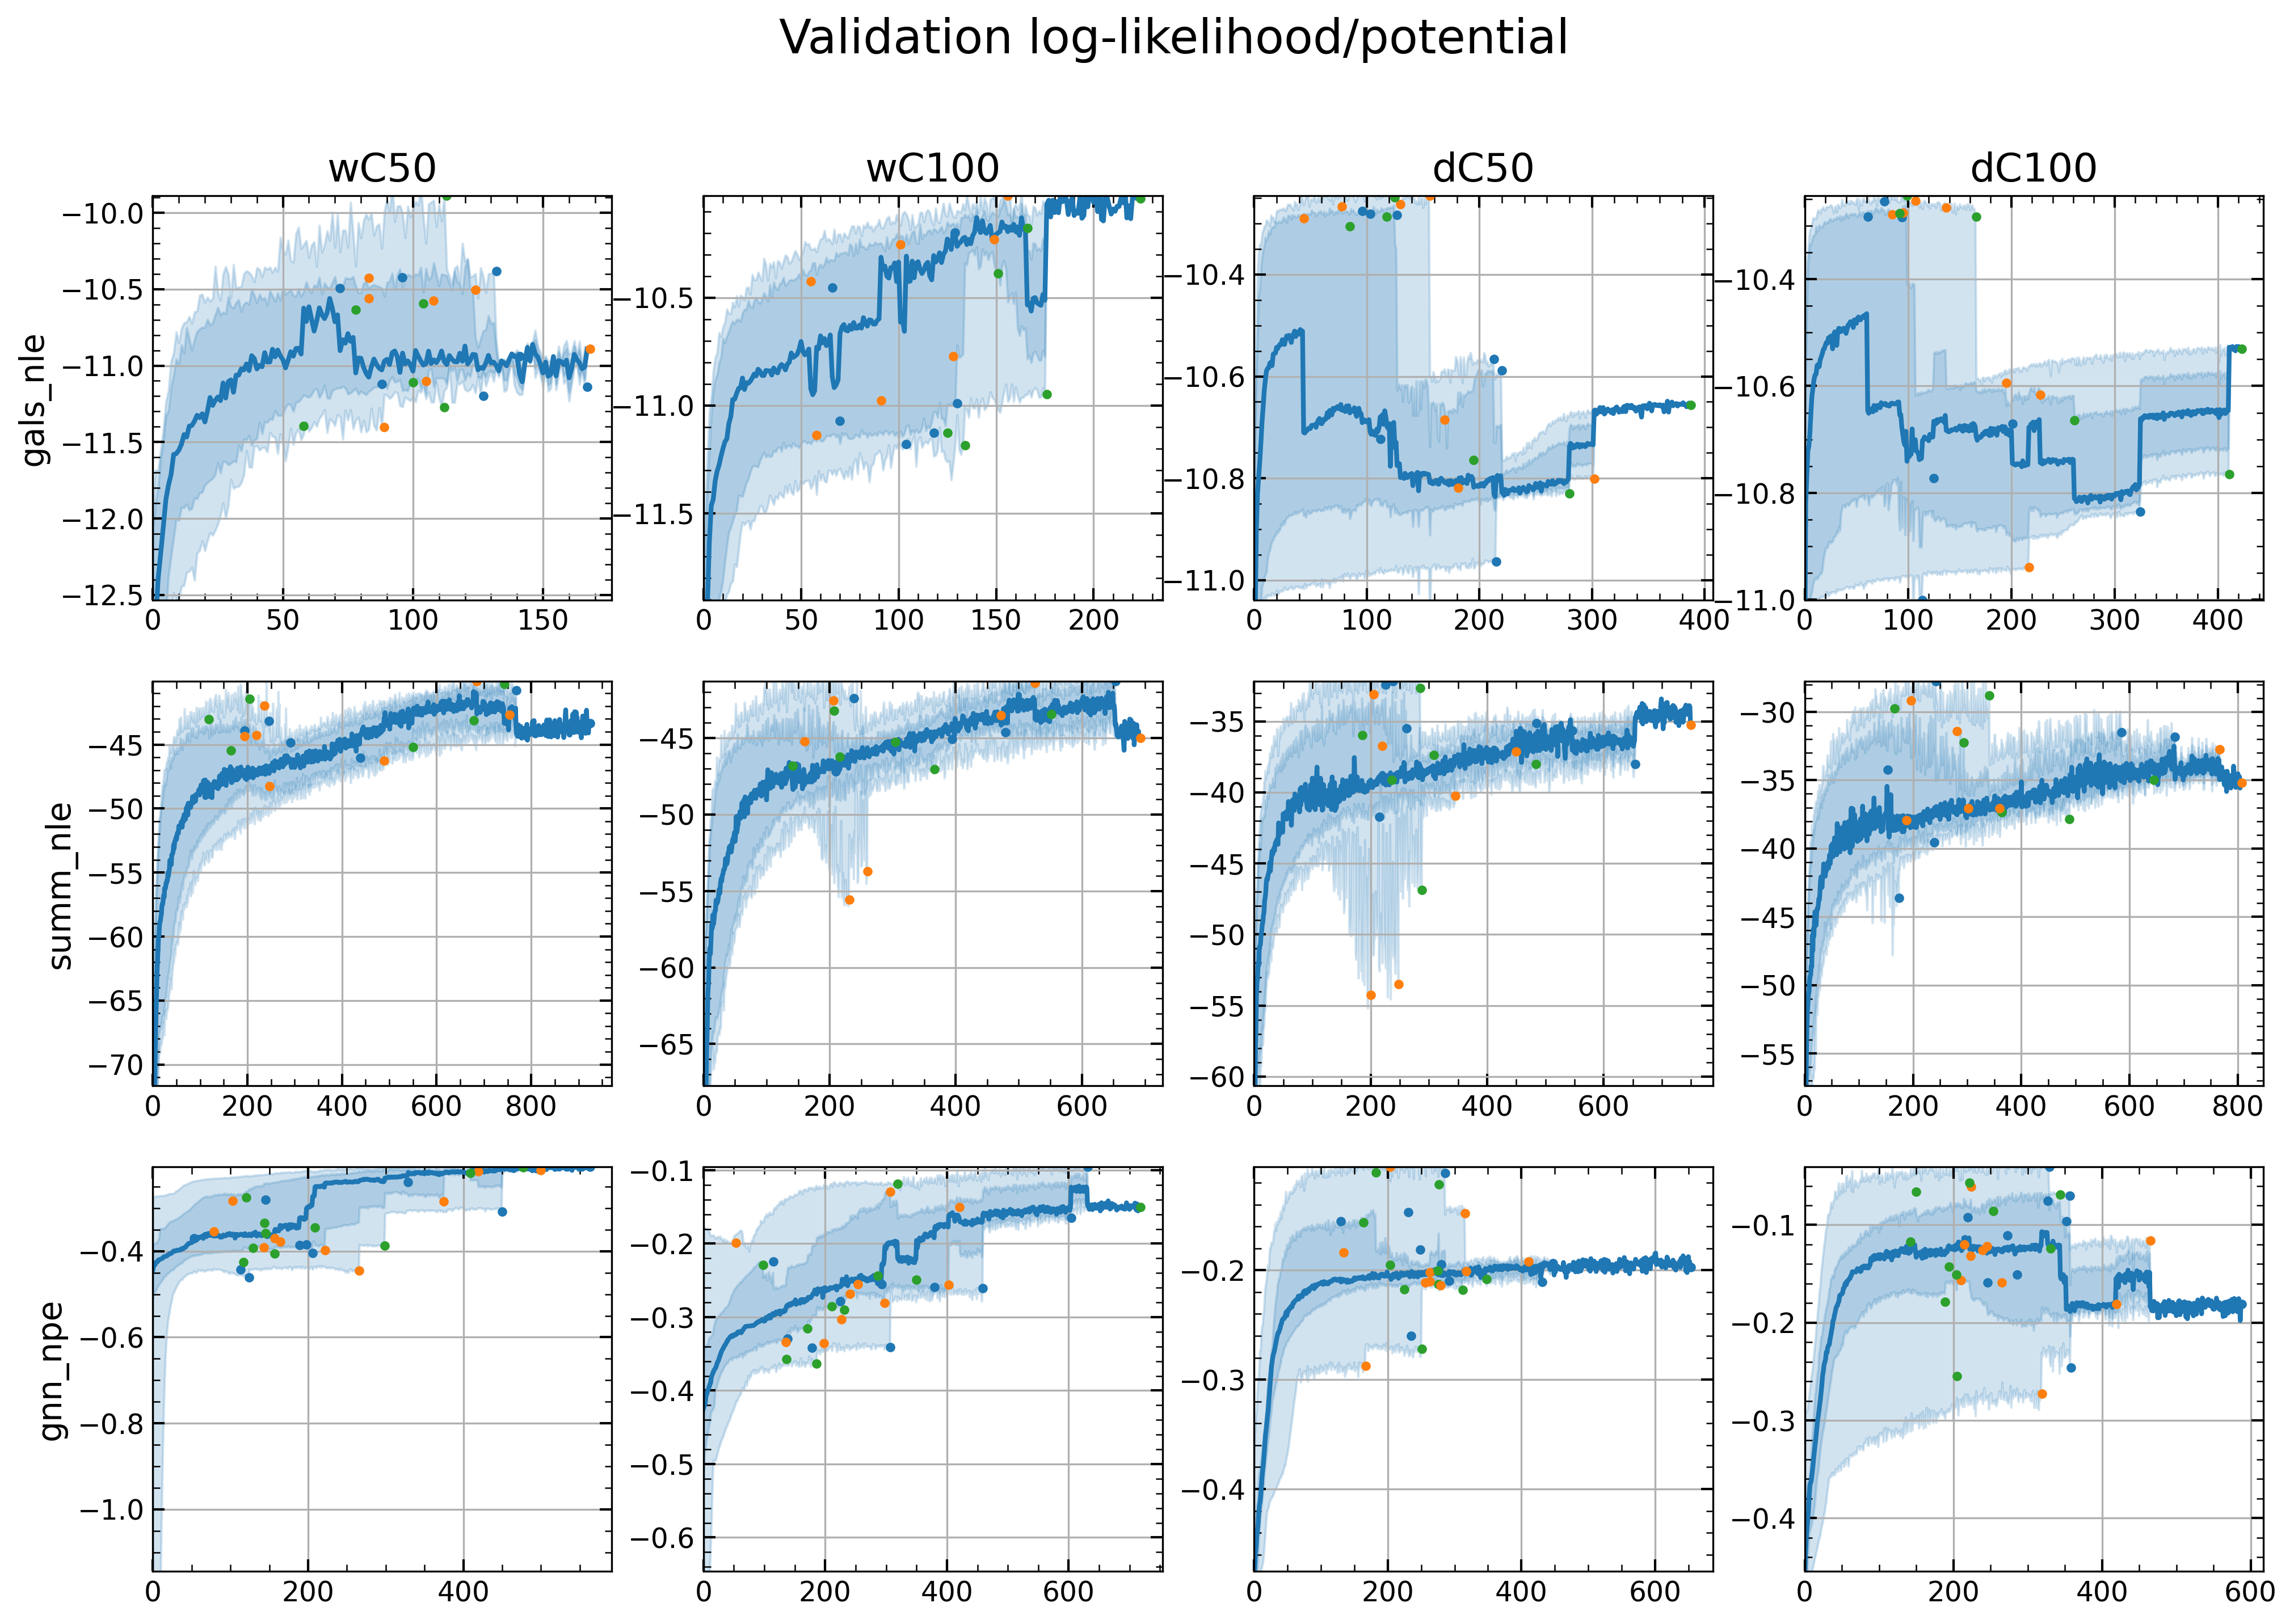

In [10]:
W, H = len(datanames), len(runnames)-1
fig, axs = plt.subplots(H, W, figsize=(W*4, H*3.5), sharex=False, sharey=False)
for i, d in enumerate(datanames):
    print(d)
    for j, r in enumerate(runnames[1:]):
        # load summaries
        summs = []
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            fn = join(mdir, dirname, 'summary.json')
            if not os.path.exists(fn):
                continue
            with open(fn, 'r') as f:
                summs.append(json.load(f))
        
        # append losses
        loss, valloss = [], []
        for s in summs:
            for m in s:
                loss.append(m['training_log_probs'])
                valloss.append(m['validation_log_probs'])

        
        ax = axs[j, i]
        # ax.semilogx()
        plot_loss(valloss, ax, color='C0', label='Training')
        for k, l in enumerate(valloss):
            ax.plot(len(l), l[-1], '.', color=f'C{k%3}')
        ymin = np.min([x[10] for x in valloss])
        ymax = np.max([x[-1] for x in valloss])
        ax.set_ylim(ymin, ymax)
        ax.set_xlim(0)

        if j == 0:
            ax.set_title(d)
        if j == W-1:
            ax.set_xlabel('Epoch')
        if i == 0:
            ax.set_ylabel(r)

fig.suptitle('Validation log-likelihood/potential', fontsize=20);

wC50
wC100
dC50
dC100


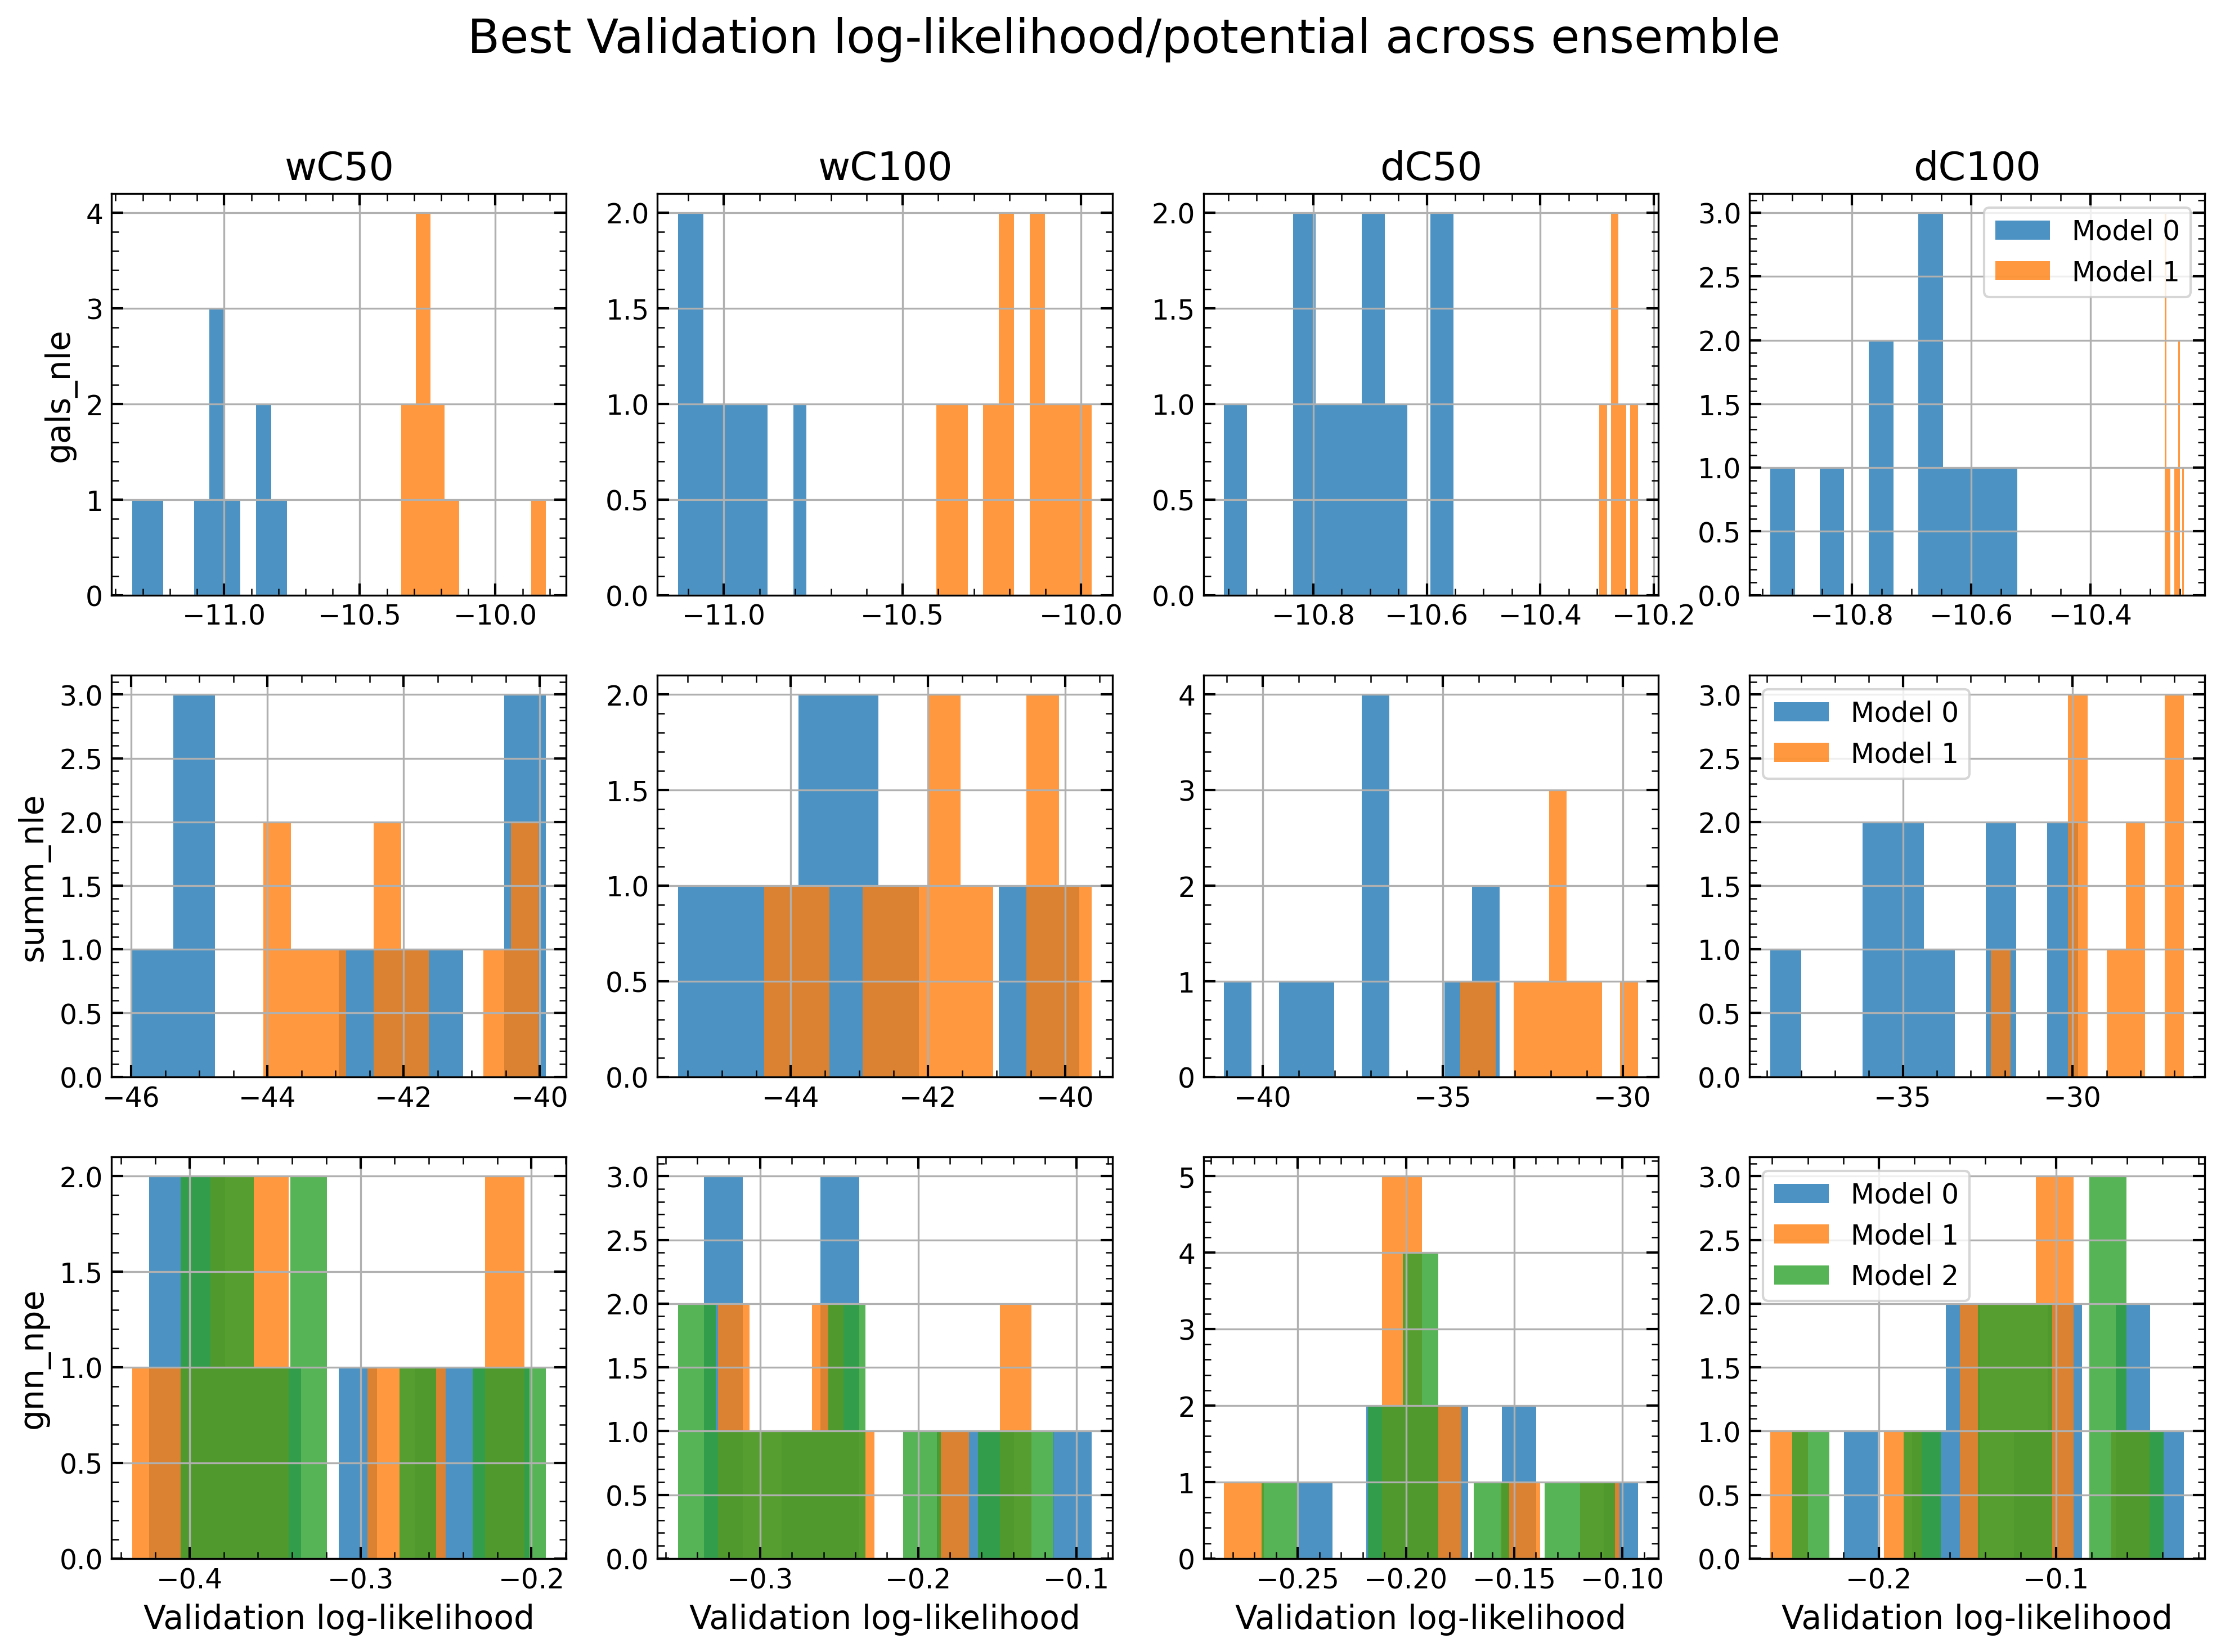

In [19]:
W, H = len(datanames), len(runnames)-1
fig, axs = plt.subplots(H, W, figsize=(W*4, H*3.5), sharex=False, sharey=False)
for i, d in enumerate(datanames):
    print(d)
    for j, r in enumerate(runnames[1:]):
        # load summaries
        summs = []
        for f in folds:
            dirname = f'apr24_{r}_{d}_f{f}'
            fn = join(mdir, dirname, 'summary.json')
            if not os.path.exists(fn):
                continue
            with open(fn, 'r') as f:
                summs.append(json.load(f))
        
        # append final
        valloss = []
        for s in summs:
            valloss.append([m['best_validation_log_prob'] for m in s])
        try:
            valloss = np.array(valloss)
        except ValueError:
            continue
        if len(valloss.shape)==3:
            valloss = valloss[...,1]
        valloss[~np.isfinite(valloss)] = -16

        
        ax = axs[j, i]
        # ax.semilogx()
        for k in range(valloss.shape[-1]):
            ax.hist(valloss[:,k], alpha=0.8, label=f'Model {k}')
        # ax.hist(valloss, label='r')
        # ymin = np.min([x[10] for x in valloss])
        # ymax = np.max([x[-1] for x in valloss])
        # ax.set_ylim(ymin, ymax)
        # ax.set_xlim(0)

        if j == 0:
            ax.set_title(d)
        if j == H-1:
            ax.set_xlabel('Validation log-likelihood')
        if i == 0:
            ax.set_ylabel(r)
        if i == W-1:
            ax.legend()

fig.suptitle('Best Validation log-likelihood/potential across ensemble', fontsize=20);

## Plot Examples

In [110]:
# Plot single cluster example
data = pd.read_csv(
    'data/raw/deep_all_03042024.dat', delimiter=' ', index_col=False,
    skipinitialspace=True)
data = pd.DataFrame(
    data.iloc[1:,:-1].values, columns=data.columns[1:]).reset_index(drop=True)
data = data.groupby('Cl_id')
idx = 227  # np.random.choice(list(data.groups.keys()))
clu = data.get_group(idx)

In [111]:
c = 2.99792458e5 # km/s
clu['vwC50'] = c*(clu['zwerr']-clu['zwC50'])/(1+clu['zwC50'])
clu['vwC100'] = c*(clu['zwerr']-clu['zwC100'])/(1+clu['zwC100'])
clu['vdC50'] = c*(clu['zwerr']-clu['zdC50'])/(1+clu['zwC50'])
clu['vdC100'] = c*(clu['zwerr']-clu['zdC100'])/(1+clu['zwC100'])
clu['Rami'] = np.sqrt((clu['xami']**2 + clu['yami']**2).astype(float))


# Apply velocity cuts
mask = np.abs(clu['vdC100']) < 5000
clu = clu[mask]

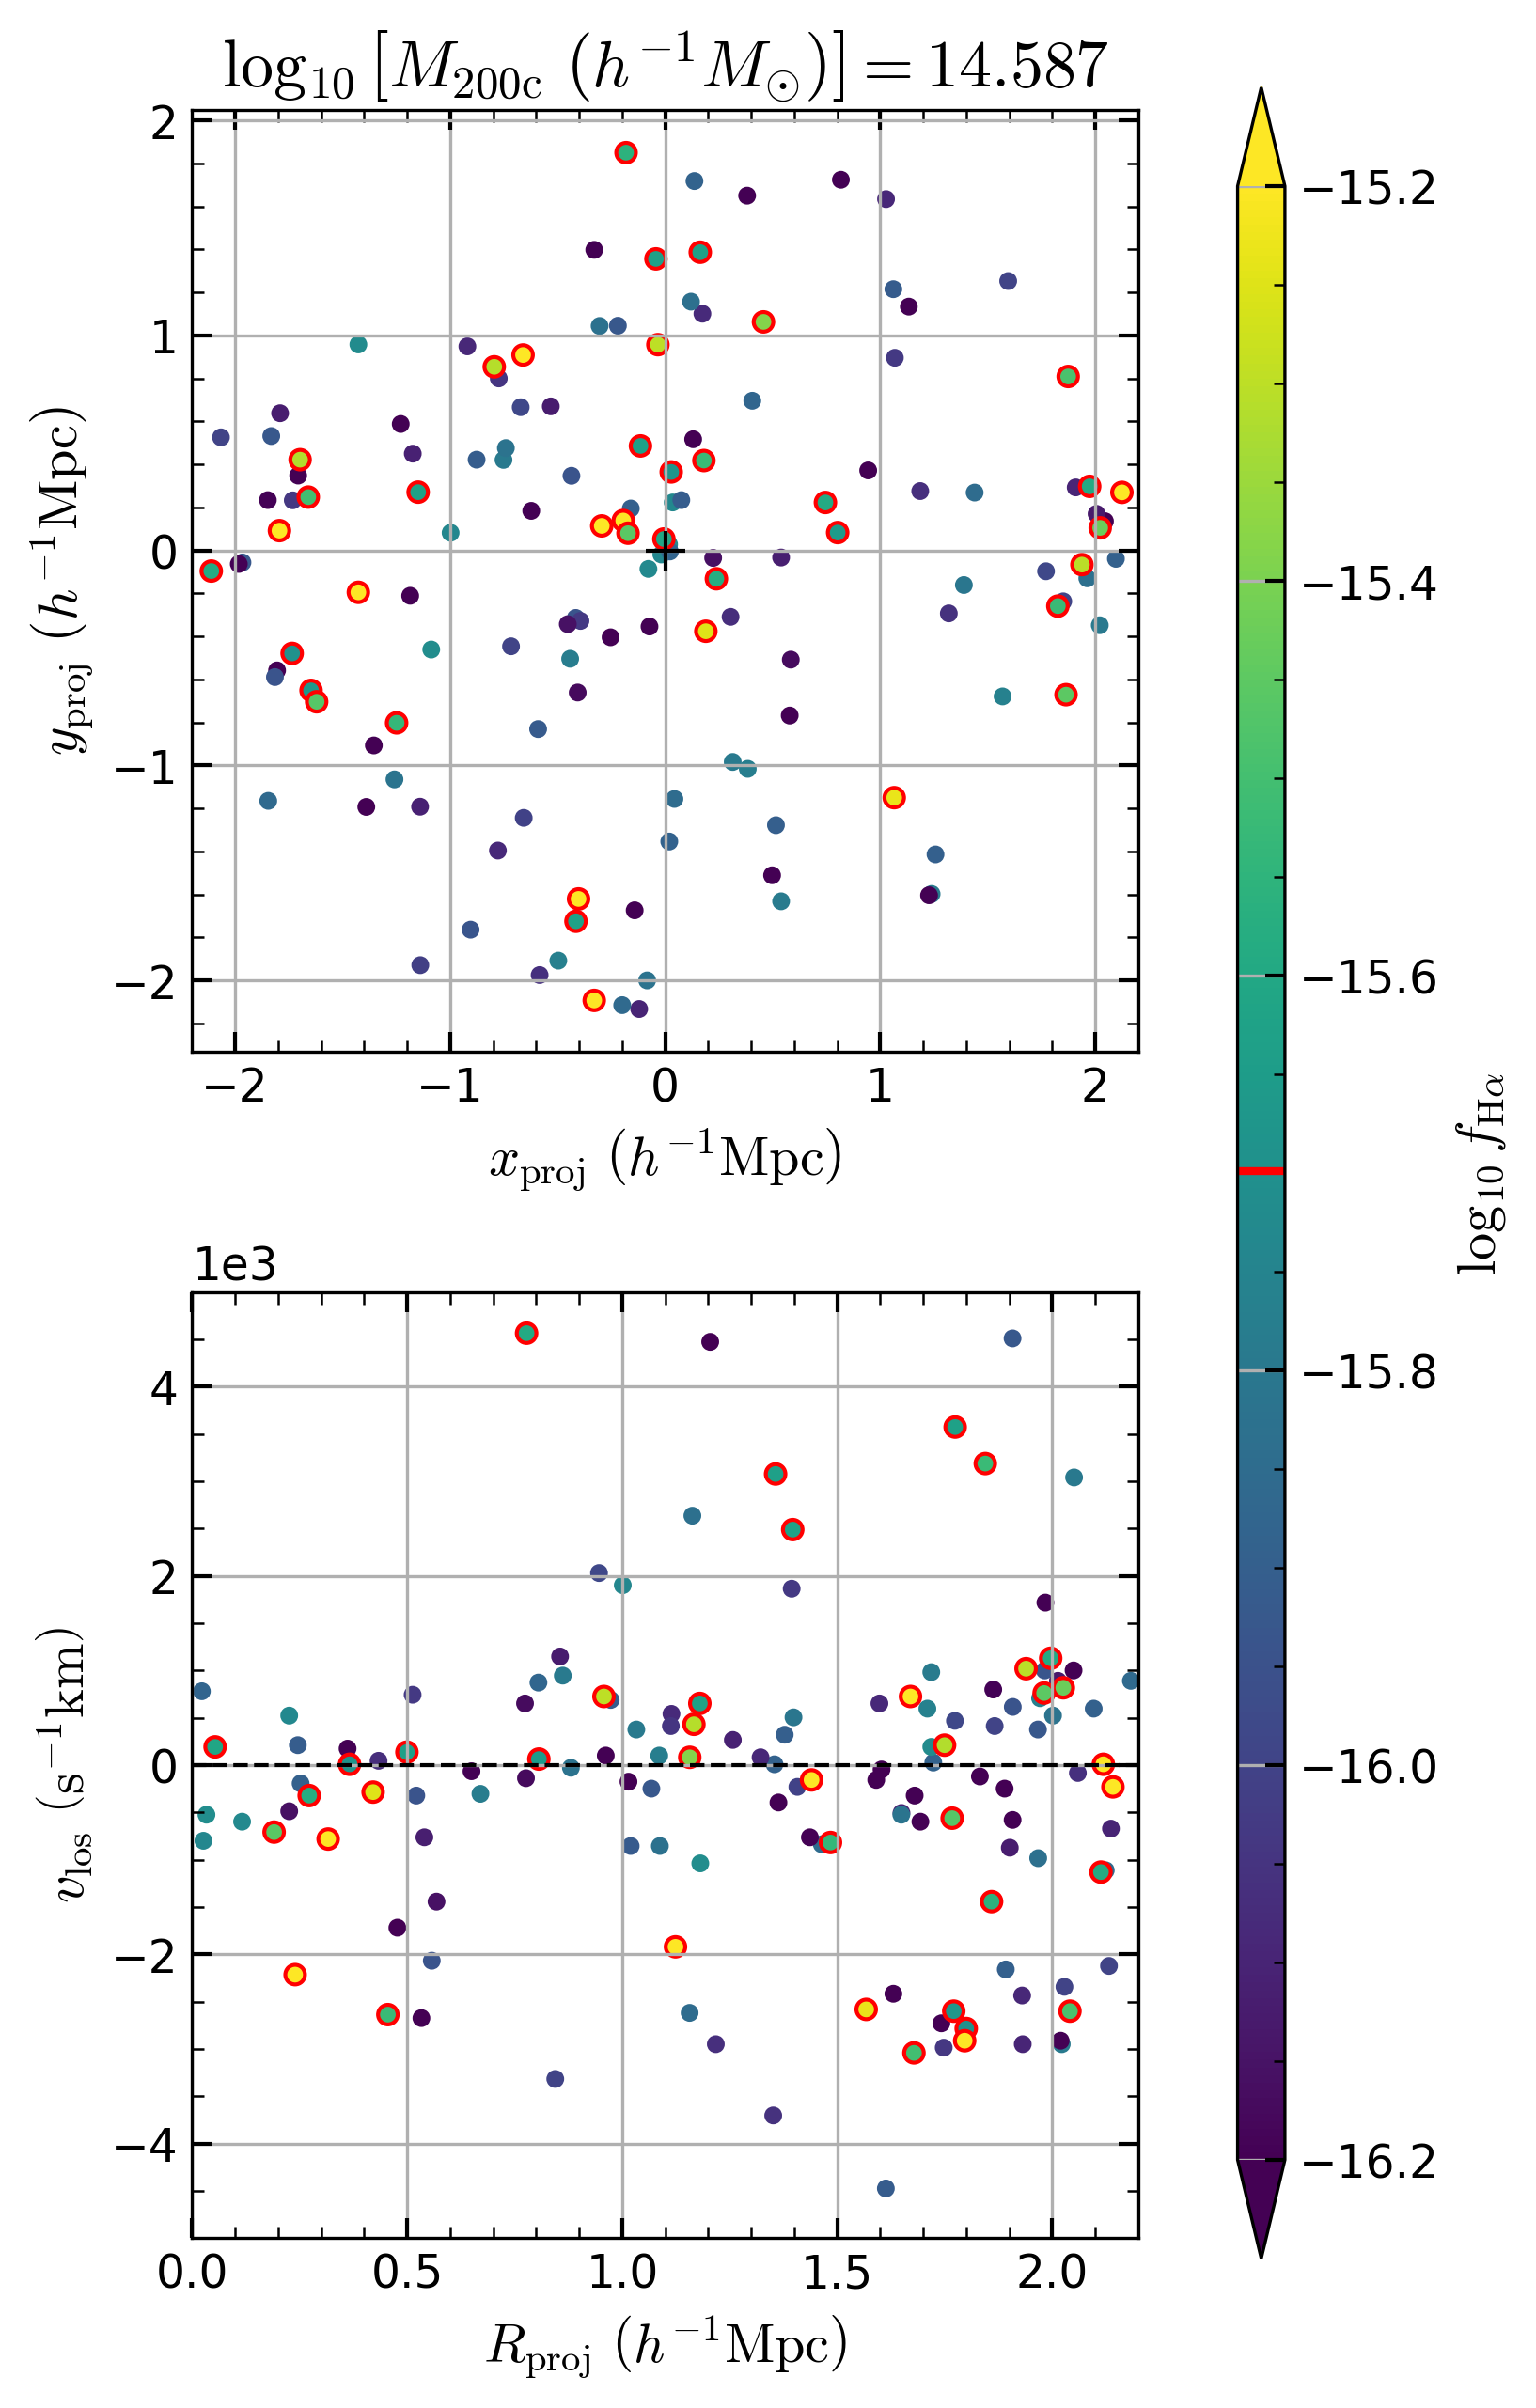

In [113]:
falpha = np.log10(2e-16)

fig = plt.figure(figsize=(5,10))
gs = mpl.gridspec.GridSpec(2,2, hspace=0.2, width_ratios=[1,0.05])
cmap, ec = 'viridis', 'red'

# sky-projected
ax = fig.add_subplot(gs[0,0])
mask = clu['fHa'] > falpha
im = ax.scatter(clu['xami'][~mask], clu['yami'][~mask], 
                marker='.', c=clu['fHa'][~mask],
                s=50,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
im = ax.scatter(clu['xami'][mask], clu['yami'][mask], 
                marker='.', c=clu['fHa'][mask],
                edgecolors=ec, lw=1., s=100,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
ax.plot(0,0, '+', c='k', ms=10)
ax.set_aspect('equal')
ax.set(xlabel=r'$x_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$y_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$')
ax.set_xlim(-2.2, 2.2)
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))
ax.set_title(r"$\log_{{10}}\left[M_{{\rm 200c}}\ \left(h^{-1}M_{\odot}\right) \right] = "
             f"{np.log10(clu['M200'].iloc[0]):.3f}$")


# dynamical
ax = fig.add_subplot(gs[1,0])
ax.axhline(0, c='k', lw=1, ls='--')
im = ax.scatter(clu['Rami'][~mask], clu['vdC100'][~mask], 
                marker='.', c=clu['fHa'][~mask],
                s=50,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
im = ax.scatter(clu['Rami'][mask], clu['vdC100'][mask], 
                marker='.', c=clu['fHa'][mask],
                edgecolors=ec, lw=1., s=100,
                cmap=cmap, vmin=-16.2, vmax=-15.2)
ax.set(xlabel=r'$R_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$v_{\rm los}\ \left({\rm s}^{-1}{\rm km}\right)$')
xlim, ylim = (0,2.2), (-5e3, 5e3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_aspect(np.diff(xlim)/np.diff(ylim))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# colorbar
ax = fig.add_subplot(gs[:,1])
plt.colorbar(im, cax=ax, label=r'$\log_{10}f_{{\rm H}\alpha}$', extend='both')
ax.axhline(np.log10(2e-16), c='r', lw=2, ls='-')

fig.savefig('figures/dyn_ex.pdf', bbox_inches='tight')

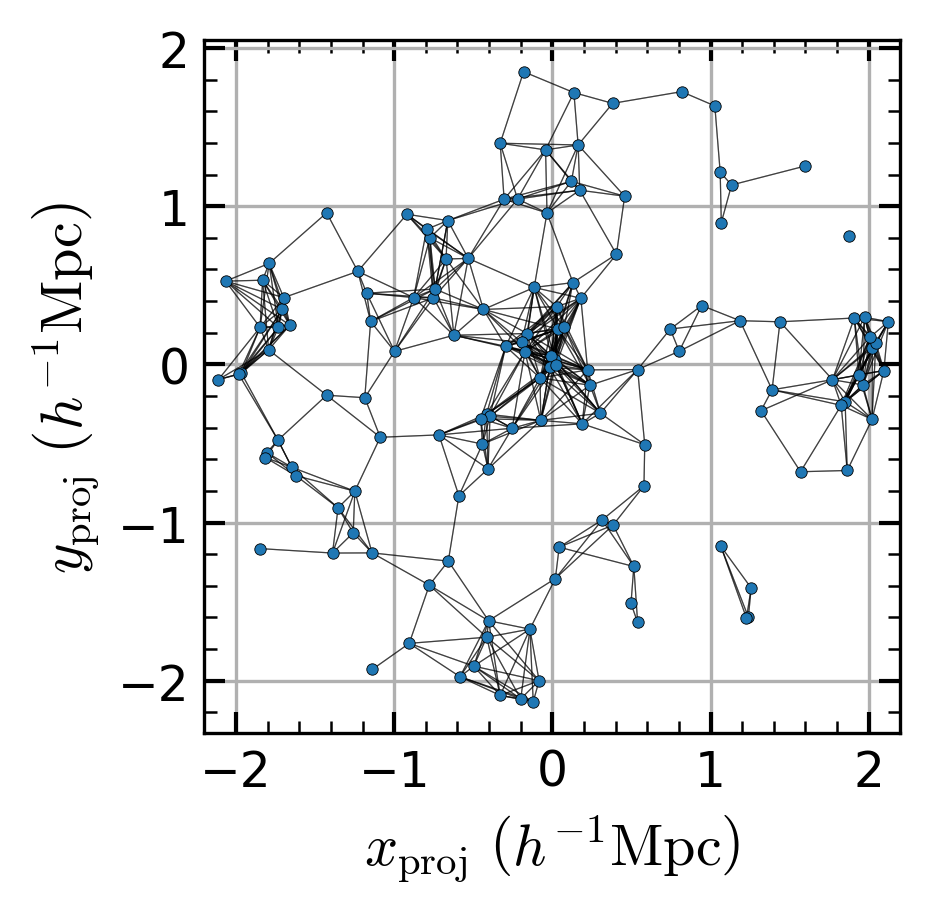

In [72]:
rmax = 0.5
graph = skn.radius_neighbors_graph(
    np.array([clu['xami'], clu['yami']]).T,
    rmax, 
    mode='distance', 
    include_self=False
).toarray()
def plot_graph(x, y, graph, ax, **kwargs):
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if graph[i,j] > 0:
                ax.plot([x[i], x[j]], [y[i], y[j]], **kwargs)

fig, axs = plt.subplots(
    1, 1, 
    figsize=(4,3),
    # gridspec_kw={'width_ratios':[1,0.05], 'wspace':0.1}
)

ax = axs  # [0]
plot_graph(clu['xami'].values, clu['yami'].values, graph, ax,
           lw=0.3, c='k', alpha=0.5, zorder=1e3)
im = ax.scatter(clu['xami'], clu['yami'], 
                marker='.', # c=clu['vdC100'],
                edgecolor='k', lw=0.2,
                s=30, vmin=-4e3, vmax=4e3,
                cmap='coolwarm', zorder=1e3)
ax.set_aspect('equal')
ax.set(xlabel=r'$x_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$y_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$')
ax.set_xlim(-2.2, 2.2)
ax.set_xticks(range(-2,3))
ax.set_yticks(range(-2,3))

# ax = axs[1]
# plt.colorbar(
#     im, cax=ax,
#     label=r'$v_{\rm los}\ \left({\rm s}^{-1}{\rm km}\right)$')
fig.savefig('figures/graph.pdf', bbox_inches='tight')

In [82]:
clu.columns

Index(['xtrue', 'ytrue', 'xami', 'yami', 'zobs', 'zwerr', 'Hmag', 'fHa',
       'Pmem', 'M', 'Comp', 'Cl_id', 'zctrue', 'zcphot', 'zwC50', 'zwC100',
       'zdC50', 'zdC100', 'M200', 'r200', 'rich', 'sig1d', 'vwC50', 'vwC100',
       'vdC50', 'vdC100', 'Rami'],
      dtype='object')

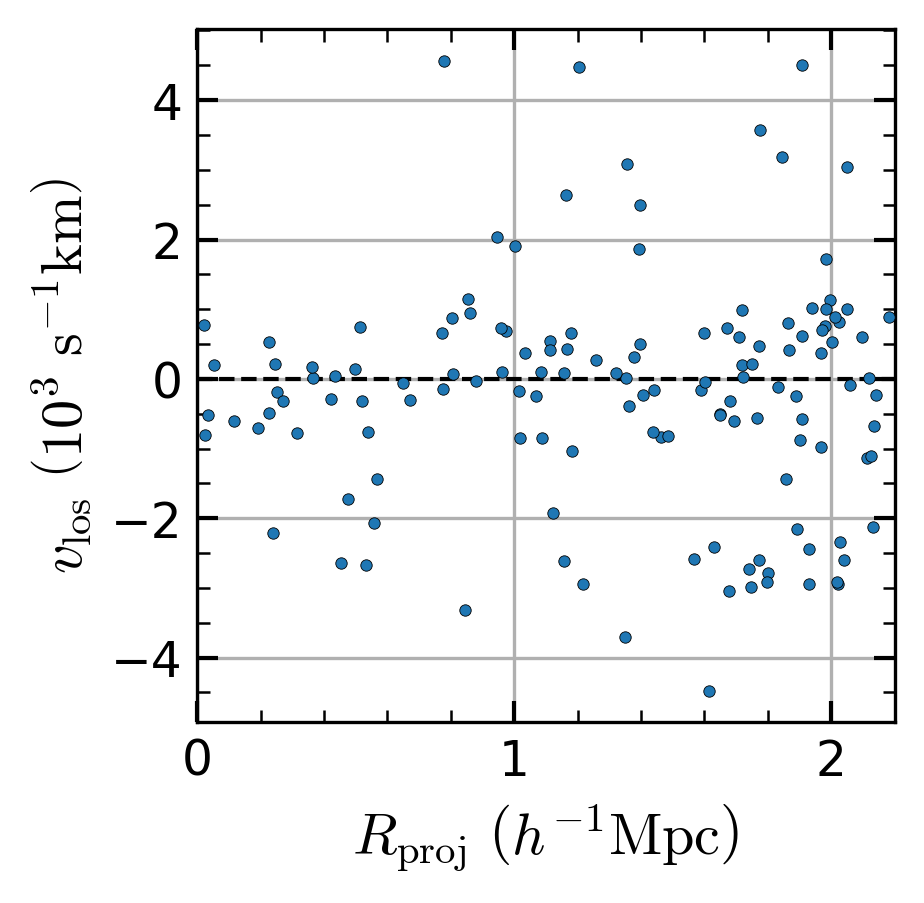

In [89]:

fig, axs = plt.subplots(
    1, 1, 
    figsize=(3,3),
)

ax = axs  
ax.axhline(0, c='k', lw=1, ls='--')
im = ax.scatter(clu['Rami'], clu['vdC100']/1e3, 
                marker='.', # c=clu['vdC100'],
                edgecolor='k', lw=0.2,
                s=30, vmin=-4e3, vmax=4e3,
                cmap='coolwarm', zorder=1e3)
# ax.set_aspect('equal')
ax.set(xlabel=r'$R_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$v_{\rm los}\ \left(10^3\ {\rm s}^{-1}{\rm km}\right)$')
ax.set_xlim(0, 2.2)
# ax.set_xticks(range(-2,3))
# ax.set_yticks(range(-2,3))

fig.savefig('figures/phasespace.pdf', bbox_inches='tight')

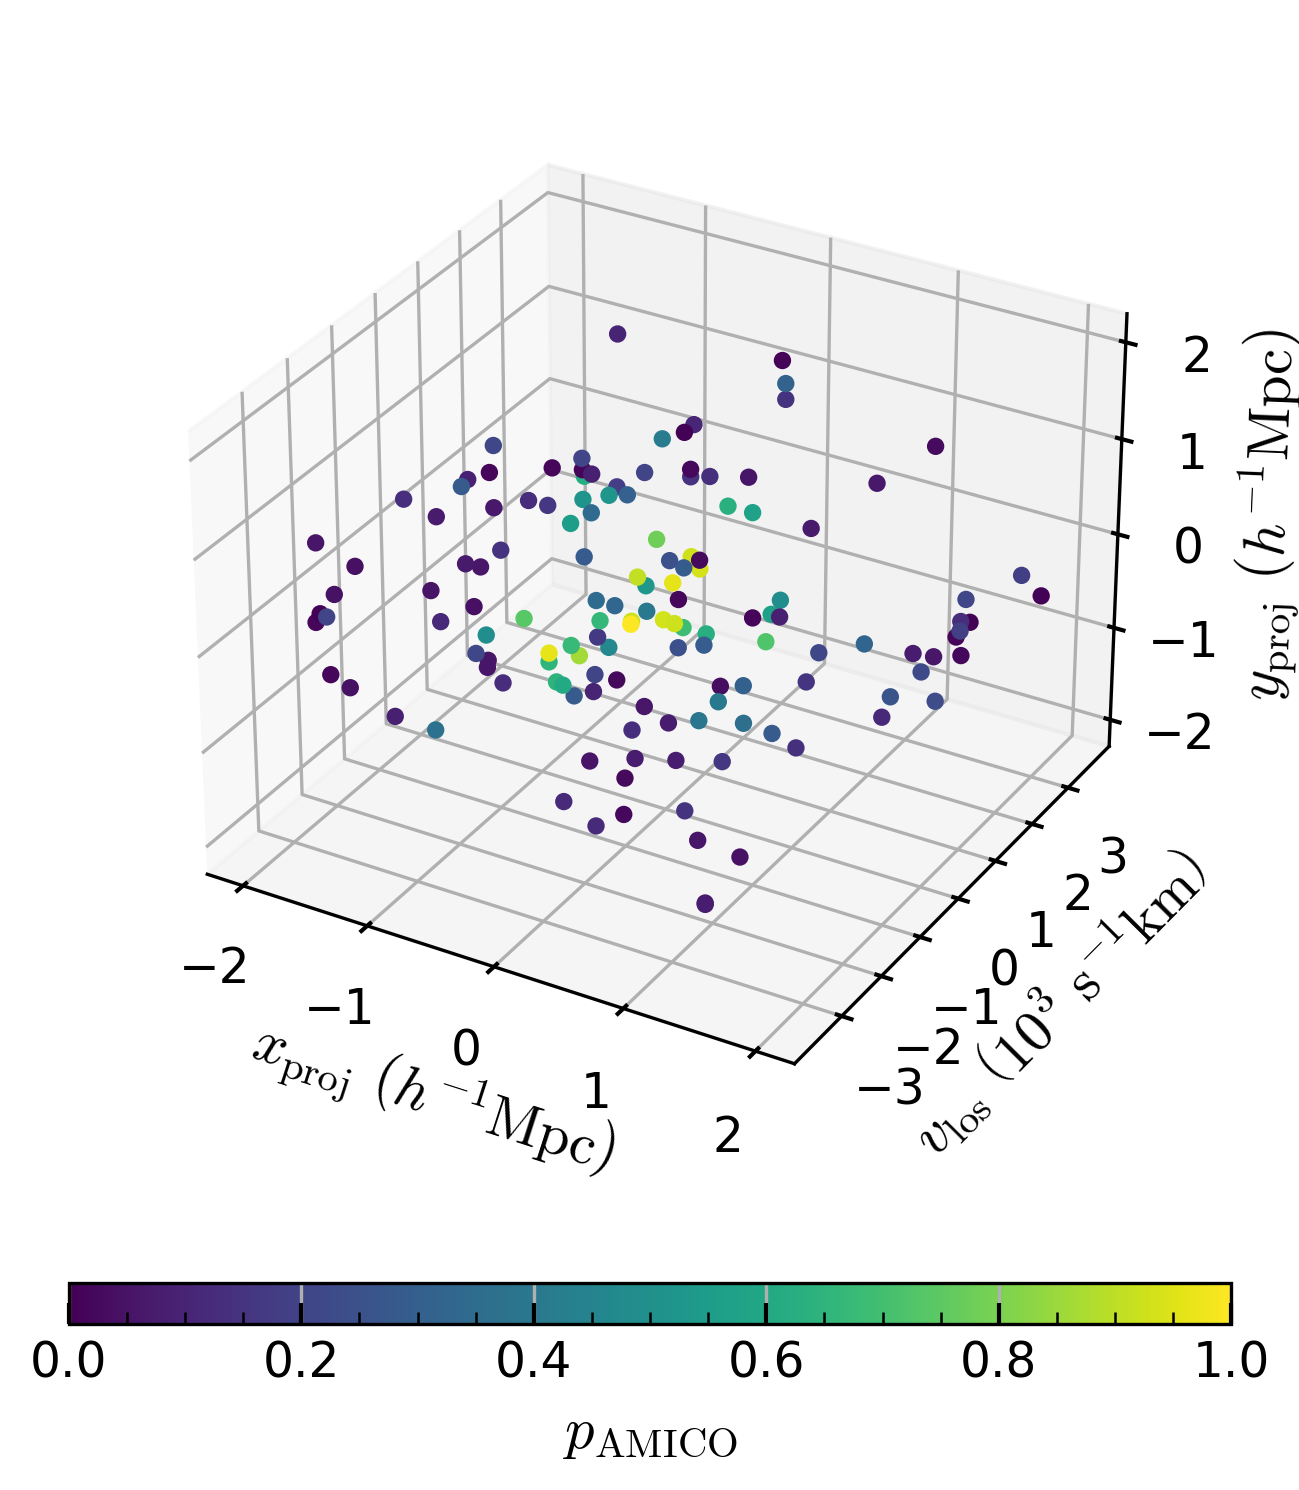

In [77]:
fig = plt.figure(figsize=(5,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.03], hspace=0.)
ax = fig.add_subplot(gs[0,0], projection='3d')
im = ax.scatter(clu['xami'], clu['vdC100']/1e3, clu['yami'],
                c=clu['Pmem'], vmin=0, vmax=1, s=10,
                alpha=1)

ax.set_box_aspect(aspect=None, zoom=0.9)
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-4, 4)
ax.set_zlim(-2.2, 2.2)
ax.set_xticks(range(-2,3))
ax.set_zticks(range(-2,3))
ax.set_yticks(np.arange(-3,4))
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)
ax.set_zticks([], minor=True)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set(xlabel=r'$x_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',
       ylabel=r'$v_{\rm los}\ \left({10^3\ \rm s}^{-1}{\rm km}\right)$',
       zlabel=r'$y_{\rm proj}\ \left(h^{-1}{\rm Mpc}\right)$',)

ax = fig.add_subplot(gs[1])
plt.colorbar(im, cax=ax, label=r'$p_{\rm AMICO}$',
             orientation='horizontal', shrink=0.9)

fig.savefig('figures/3d.pdf', bbox_inches='tight');

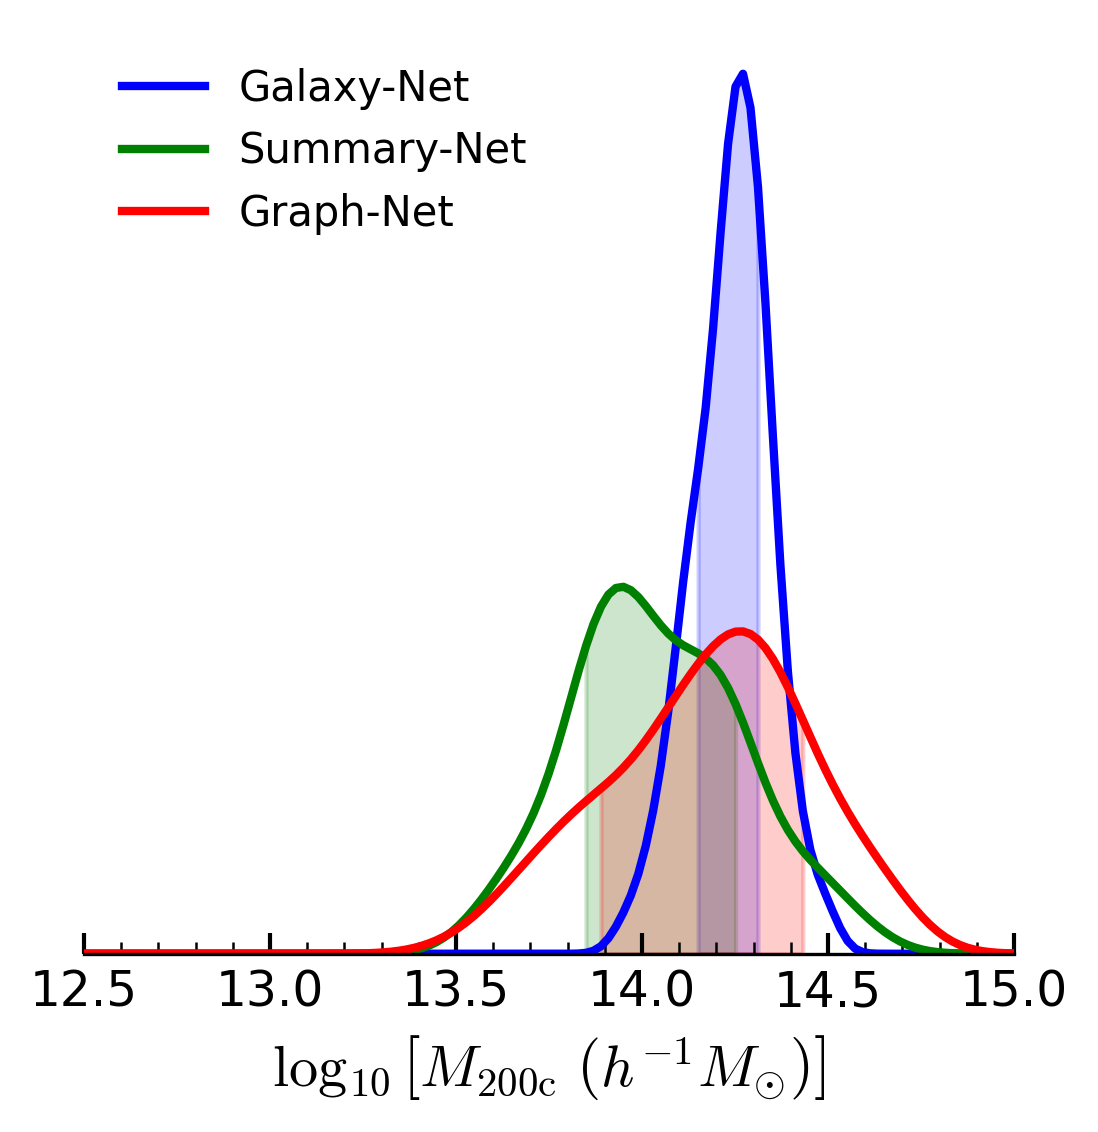

In [80]:
from scipy.stats import gaussian_kde

d = 'dC100'
mlist = ['gals_nle', 'summ_nle', 'gnn_npe']
cs = ['b','g','r']

# check all predictions are not nan
ind = idx
# flag = False
# while not flag:
#     ind = np.random.choice(len(preds[d][mlist[0]]))
    
#     flag = True
#     for m in mlist:
#         flag &= not (np.isnan(preds[d][m][ind]).any())

fig, ax = plt.subplots(figsize=(4.,4.))
x_ = np.linspace(12, 16, 200)
for i, m in enumerate(mlist):
    kde = gaussian_kde(preds[d][m][ind][...,0])
    y_ = kde.pdf(x_)
    ax.plot(x_, y_, c=cs[i], label=modeltitles[m])

    # calculate confidence interval
    p_ = np.percentile(preds[d][m][ind][...,0], q=(16,84))
    j = np.searchsorted(x_, p_)
    ax.fill_between(x_[j[0]:j[1]], [0]*(j[1]-j[0]), y_[j[0]:j[1]], 
                    color=cs[i], alpha=0.2)


leg = ax.legend(fontsize=10, frameon=False)
ax.grid(None)
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', top=False)
ax.set_ylim(0)
ax.set_xlim(12.5, 15)
ax.set_xlabel(r"$\log_{{10}}\left[M_{{\rm 200c}}\ \left(h^{-1}M_{\odot}\right) \right]$")

fig.savefig('figures/posterior.pdf', bbox_inches='tight')

## Compute histogram

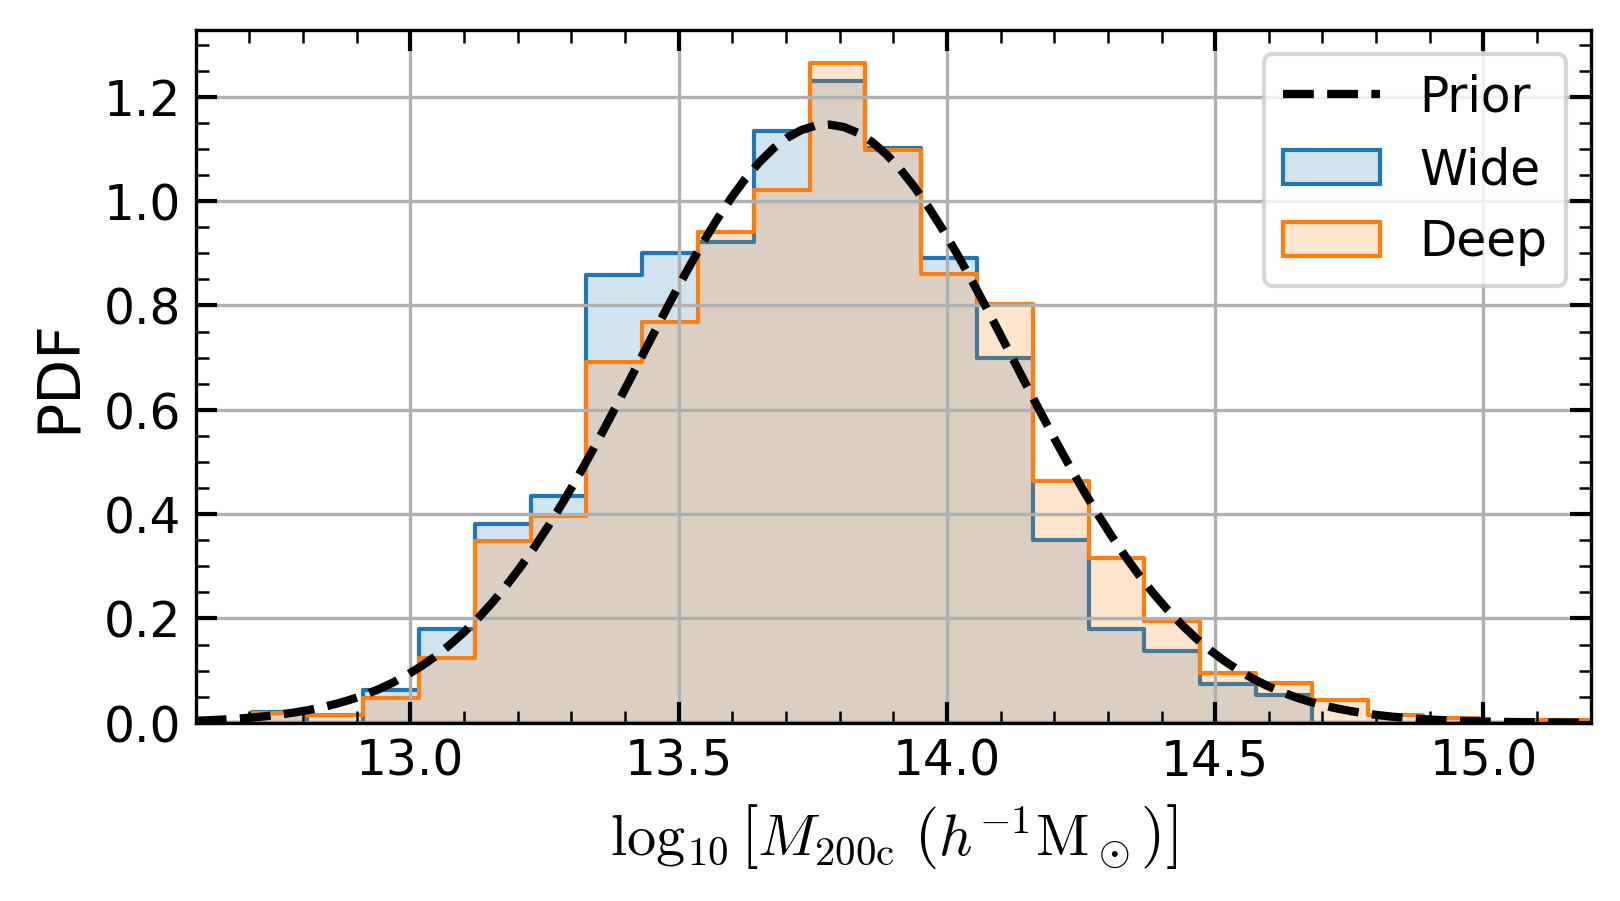

In [171]:
from scipy.stats import norm
def cen(edges):
    return (edges[:-1] + edges[1:])/2

fig, ax = plt.subplots(1, 1, figsize=(6,3))

N = 25
extent = 12.6, 15.2
x_ = np.linspace(*extent, 100)
y_ = norm.pdf(x_, loc=13.776, scale=0.3479)
ax.plot(x_, y_, 'k--', label='Prior')

data = pd.DataFrame()
for d in datanames:
    if '100' not in d:
        continue
    if d[0] == 'w':
        label = 'Wide'
    elif d[0] == 'd':
        label='Deep'
    sns.histplot(pd.DataFrame(theta[d]), x=0, bins=N, kde=False, common_norm=False,
                 alpha=0.2,  stat='density', binrange=extent,
                 label=label, element='step', ax=ax)
             
ax.set(xlabel=r'$\log_{10}\left[M_{\rm 200c}\ \left(h^{-1}{\rm M}_\odot\right)\right]$',
       ylabel='PDF')
ax.set_xlim(*extent)
ax.set_ylim(0)
ax.legend()

fig.savefig('figures/prior.pdf')

## Plot True vs. Predicted

In [24]:
xlim = min(x.min() for x in theta.values()), max(x.max() for x in theta.values())
xlim = np.array(xlim)
ylim = xlim.mean() + np.array([-1.2, 1.4])*xlim.ptp()/2

rlim = 1, 100  # richness limits
rlim = np.log10(rlim)

def sample_even(x, N, bins=40):
    # sample from x to form a uniform distribution
    ind = np.digitize(x, np.linspace(*xlim, bins+1))
    to_choose = []
    for i in range(1, bins+1):
        binx = np.argwhere(ind == i).flatten()
        to_choose.append(
            np.random.choice(binx, min(len(binx), N//bins+1), replace=False)
        )
    to_choose = np.concatenate(to_choose)
    mask = np.zeros(len(x), dtype=bool)
    mask[to_choose] = True
    return mask

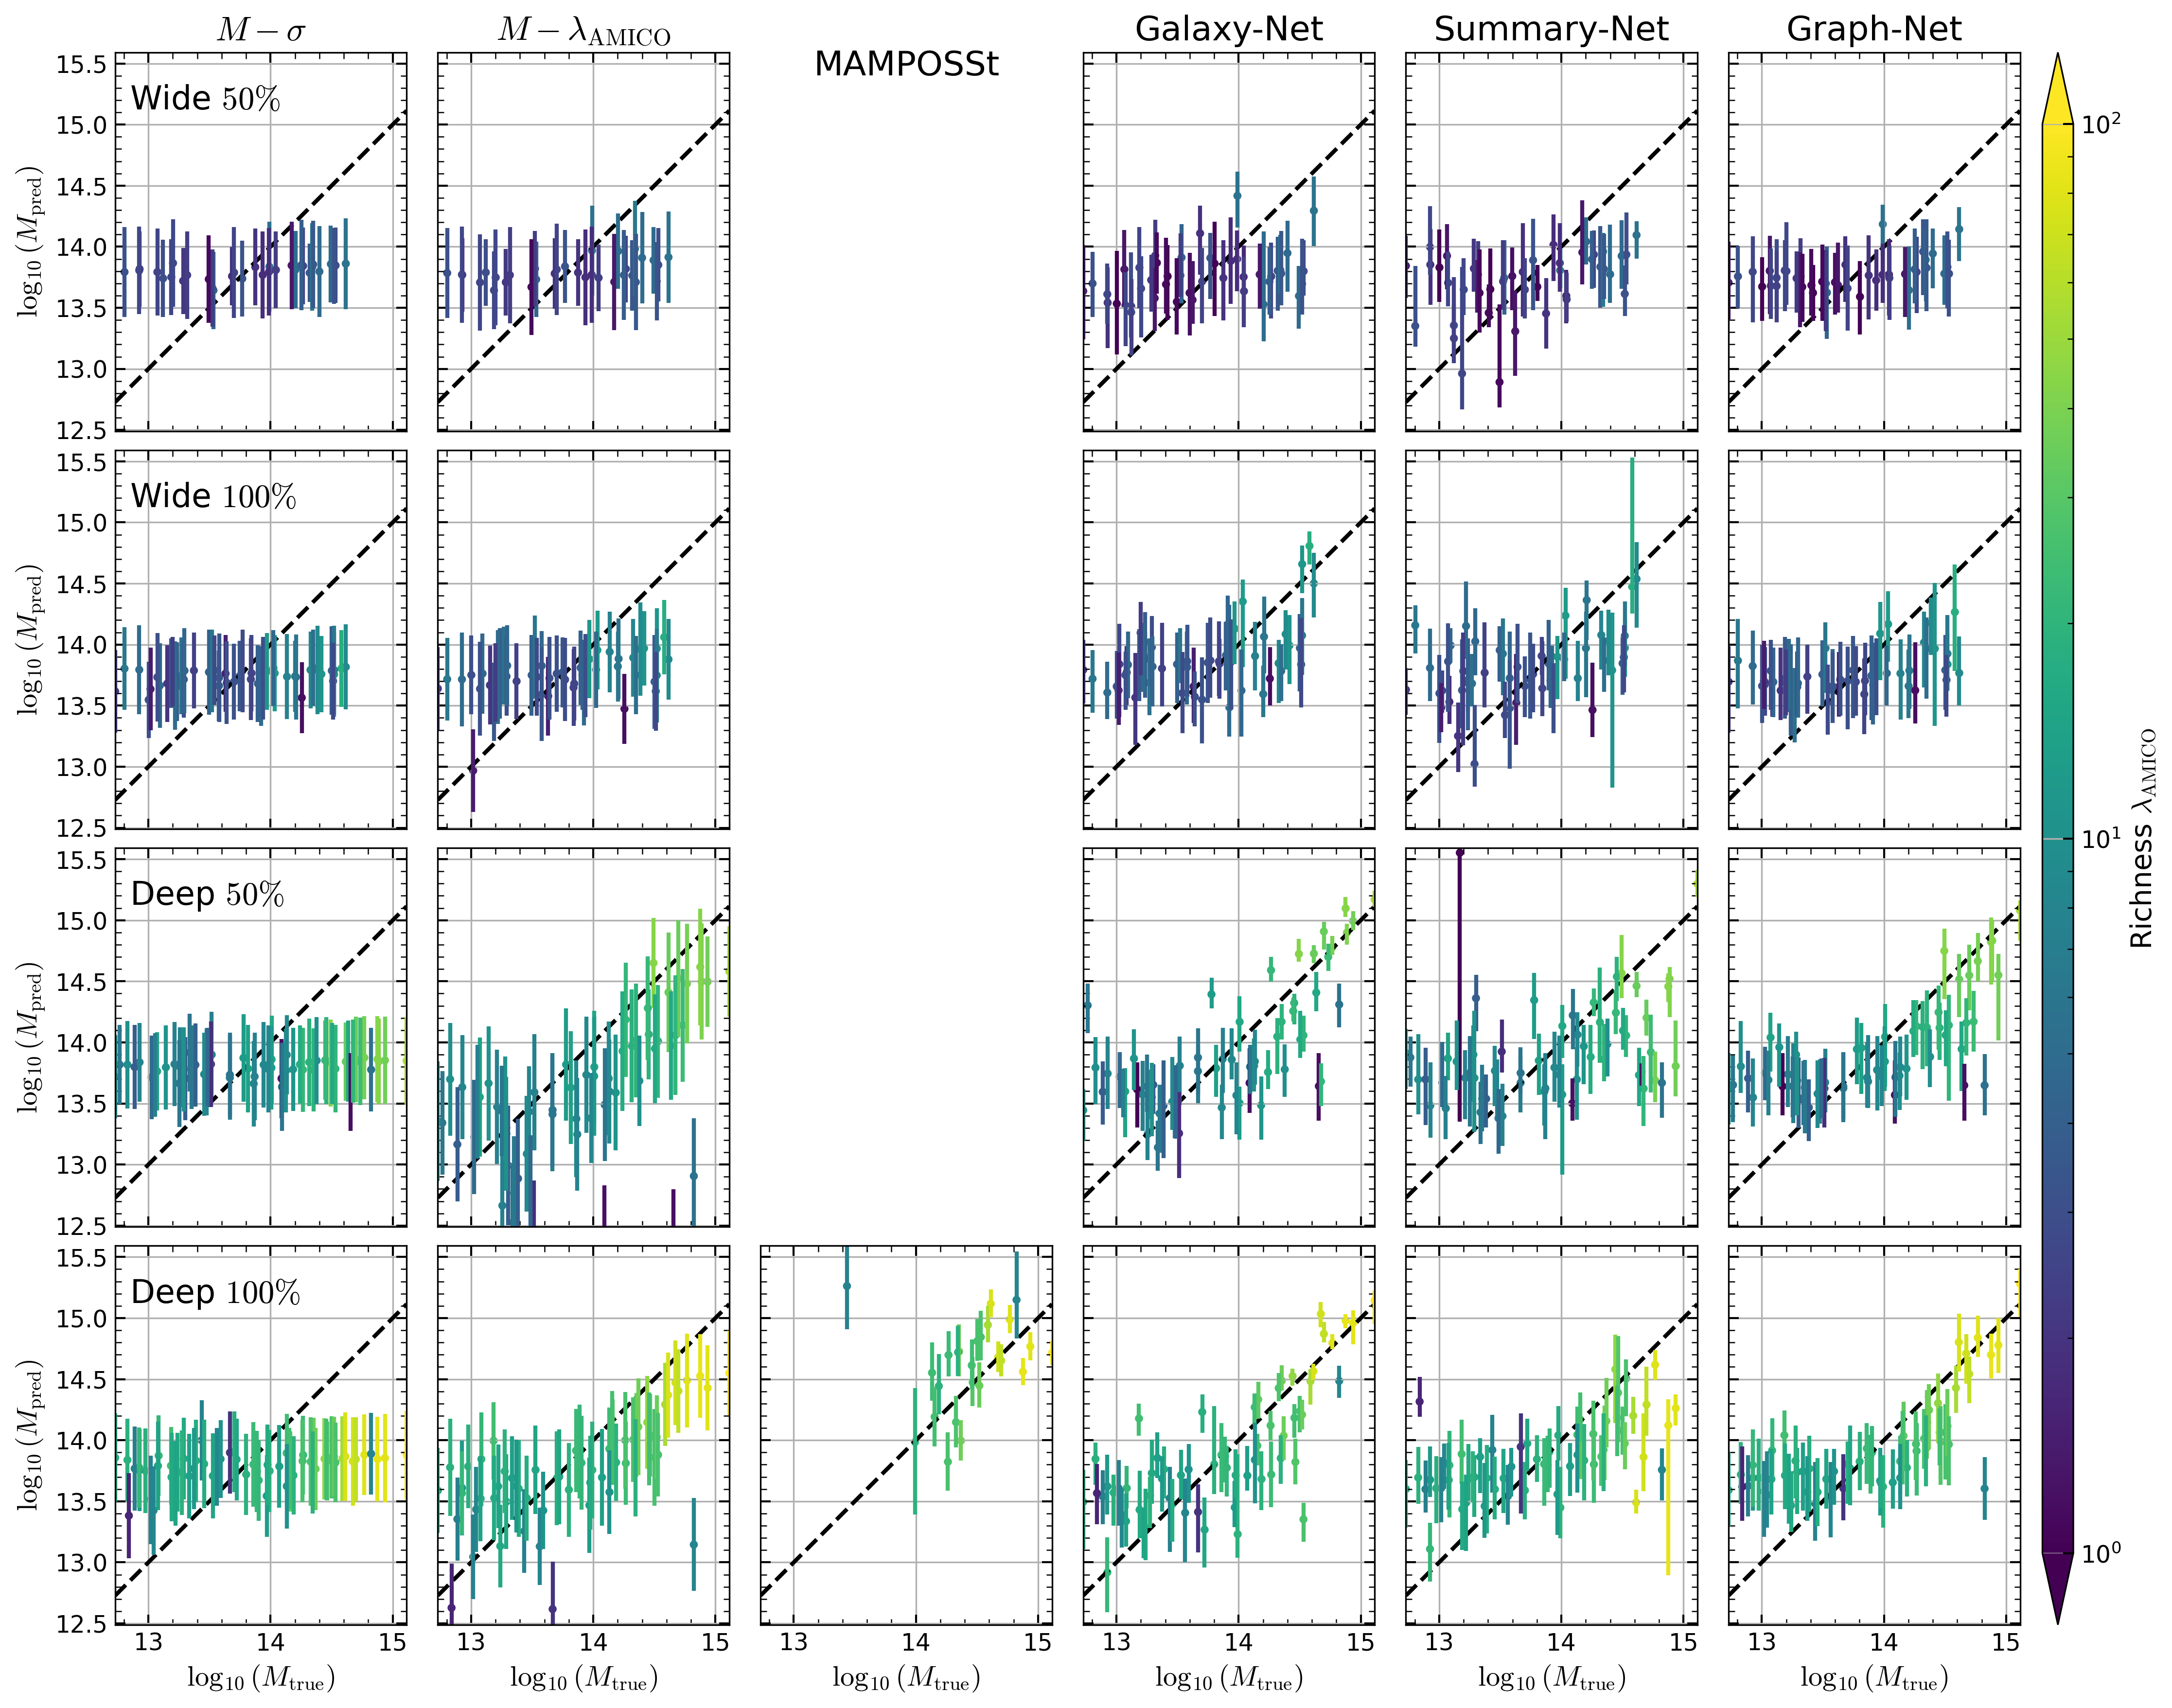

In [28]:
H, W = len(datanames), len(modelnames)
to_plot = 80

fig = plt.figure(figsize=(W*2.9, H*3.5))
gs = fig.add_gridspec(H, W+1, width_ratios=[1]*W+[0.1], wspace=0.05, hspace=0.05)

cmap = plt.cm.get_cmap('viridis')
for i, d in enumerate(datanames):
    mask = sample_even(theta[d], to_plot)
    _r = np.log10(richs[d])
    _c = cmap((_r-rlim[0])/rlim.ptp())

    for j, m in enumerate(modelnames):
        ax = fig.add_subplot(gs[i, j], aspect='equal')
        if i==0:
            ax.set_title(modeltitles[m])
        if m not in percs[d]:  # skip if model not available
            ax.axis('off')
            continue

        ax.plot(xlim, xlim, 'k--')
        ax.errorbar(
            theta[d][mask], percs[d][m][2,mask], 
            yerr=[percs[d][m][2,mask]-percs[d][m][0,mask], percs[d][m][1,mask]-percs[d][m][2,mask]], 
            fmt='none', ecolor=_c[mask]
        )
        ax.scatter(theta[d][mask], percs[d][m][2,mask], marker='.', c=_c[mask])

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        if j==0:
            ax.set_ylabel('$\log_{10}(M_{\\rm pred})$')
            ax.text(0.05, 0.85, datatitles[d], 
                    fontsize=16, transform=ax.transAxes)
        else:
            ax.set_yticklabels([])
        if i==H-1:
            ax.set_xlabel('$\log_{10}(M_{\\rm true})$')
        else:
            ax.set_xticklabels([])
ax = fig.add_subplot(gs[:, -1])
norm = mcolors.LogNorm(vmin=10**rlim[0], vmax=10**rlim[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=ax, label='Richness $\lambda_{\\rm AMICO}$', extend='both')
fig.savefig('figures/true_vs_pred.pdf', bbox_inches='tight');

# Create comparison table

In [29]:
from scipy.stats import norm, pearsonr

# richmin = 20
def calc_row(true, perc, rich):
    med = perc[-1]
    err = np.nanmean(np.abs(perc[-1] - perc[:-1]), axis=0)

    # quality control
    mask = (med > 12) & (med < 16)
    mask &= err < 1
    true, med, err, rich = true[mask], med[mask], err[mask], rich[mask]

    out = []
    # stdtot
    out += [np.nanstd(true - med)]

    # # std10
    # mask = rich >= richmin
    # if np.sum(~np.isnan(med[mask])) > 0:
    #     out += [np.nanstd(true[mask] - med[mask])]
    # else:
    #     out += [np.nan]

    # rs
    out += [pearsonr(true, med)[0]]

    # log-likelihood
    loglik = norm.logpdf(x=med, loc=true, scale=err)
    loglik = np.nanmean(loglik)
    out += [loglik]

    return out

out = []
for m in modelnames:
    out += [[]]
    for d in datanames:
        if m in percs[d].keys():
            out[-1] += [calc_row(theta[d][:,0], percs[d][m], richs[d])]
        else:
            out[-1] += [[np.nan]*3]

out = np.array(out)  # (Nmodels, Ndata, Nmetrics)

# # temp
# b = [np.nanargmin(out[..., i, 1], axis=0) 
#      if (not np.all(np.isnan(out[..., i, 1]))) else -1
#      for i in range(out.shape[1])]

best = np.stack([
    np.nanargmin(out[...,0], axis=0),  # stdtot
    np.nanargmax(out[...,1], axis=0),  # rs
    np.nanargmax(out[...,2], axis=0),  # logL
], axis=0)  # (Nmetrics, Ndata)

for i, m in enumerate(modelnames):
    s = f"{modeltitles[m]} & "
    for j in range(out.shape[1]):
        for k, v in enumerate(out[i,j]):
            if np.isnan(v):
                s += ' - '
            elif best[k,j] == i:
                s += f"\\textbf{{{v:.3f}}}"
            else:
                s += f"{v:.3f}"
            s += ' & '
    print(s[:-2] + '\\\\')

$M-\sigma$ & 0.325 & 0.135 & \textbf{-0.279} & 0.324 & 0.163 & -0.288 & 0.341 & 0.194 & -0.343 & 0.337 & 0.244 & -0.331 \\
$M-\lambda_{\rm AMICO}$ & 0.329 & 0.193 & -0.295 & 0.327 & 0.235 & -0.299 & 0.404 & 0.450 & -0.682 & 0.356 & 0.435 & -0.406 \\
MAMPOSSt &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  &  -  & 0.505 & 0.156 & -2.884 \\
Galaxy-Net & 0.326 & 0.279 & -0.349 & 0.329 & 0.314 & -0.409 & 0.341 & 0.485 & -0.911 & 0.362 & 0.489 & -1.646 \\
Summary-Net & 0.396 & 0.162 & -0.932 & 0.383 & 0.195 & -0.837 & 0.364 & 0.355 & -1.067 & 0.360 & 0.346 & -1.020 \\
Graph-Net & \textbf{0.319} & \textbf{0.299} & -0.287 & \textbf{0.310} & \textbf{0.325} & \textbf{-0.265} & \textbf{0.297} & \textbf{0.525} & \textbf{-0.228} & \textbf{0.287} & \textbf{0.566} & \textbf{-0.196} \\


mamp


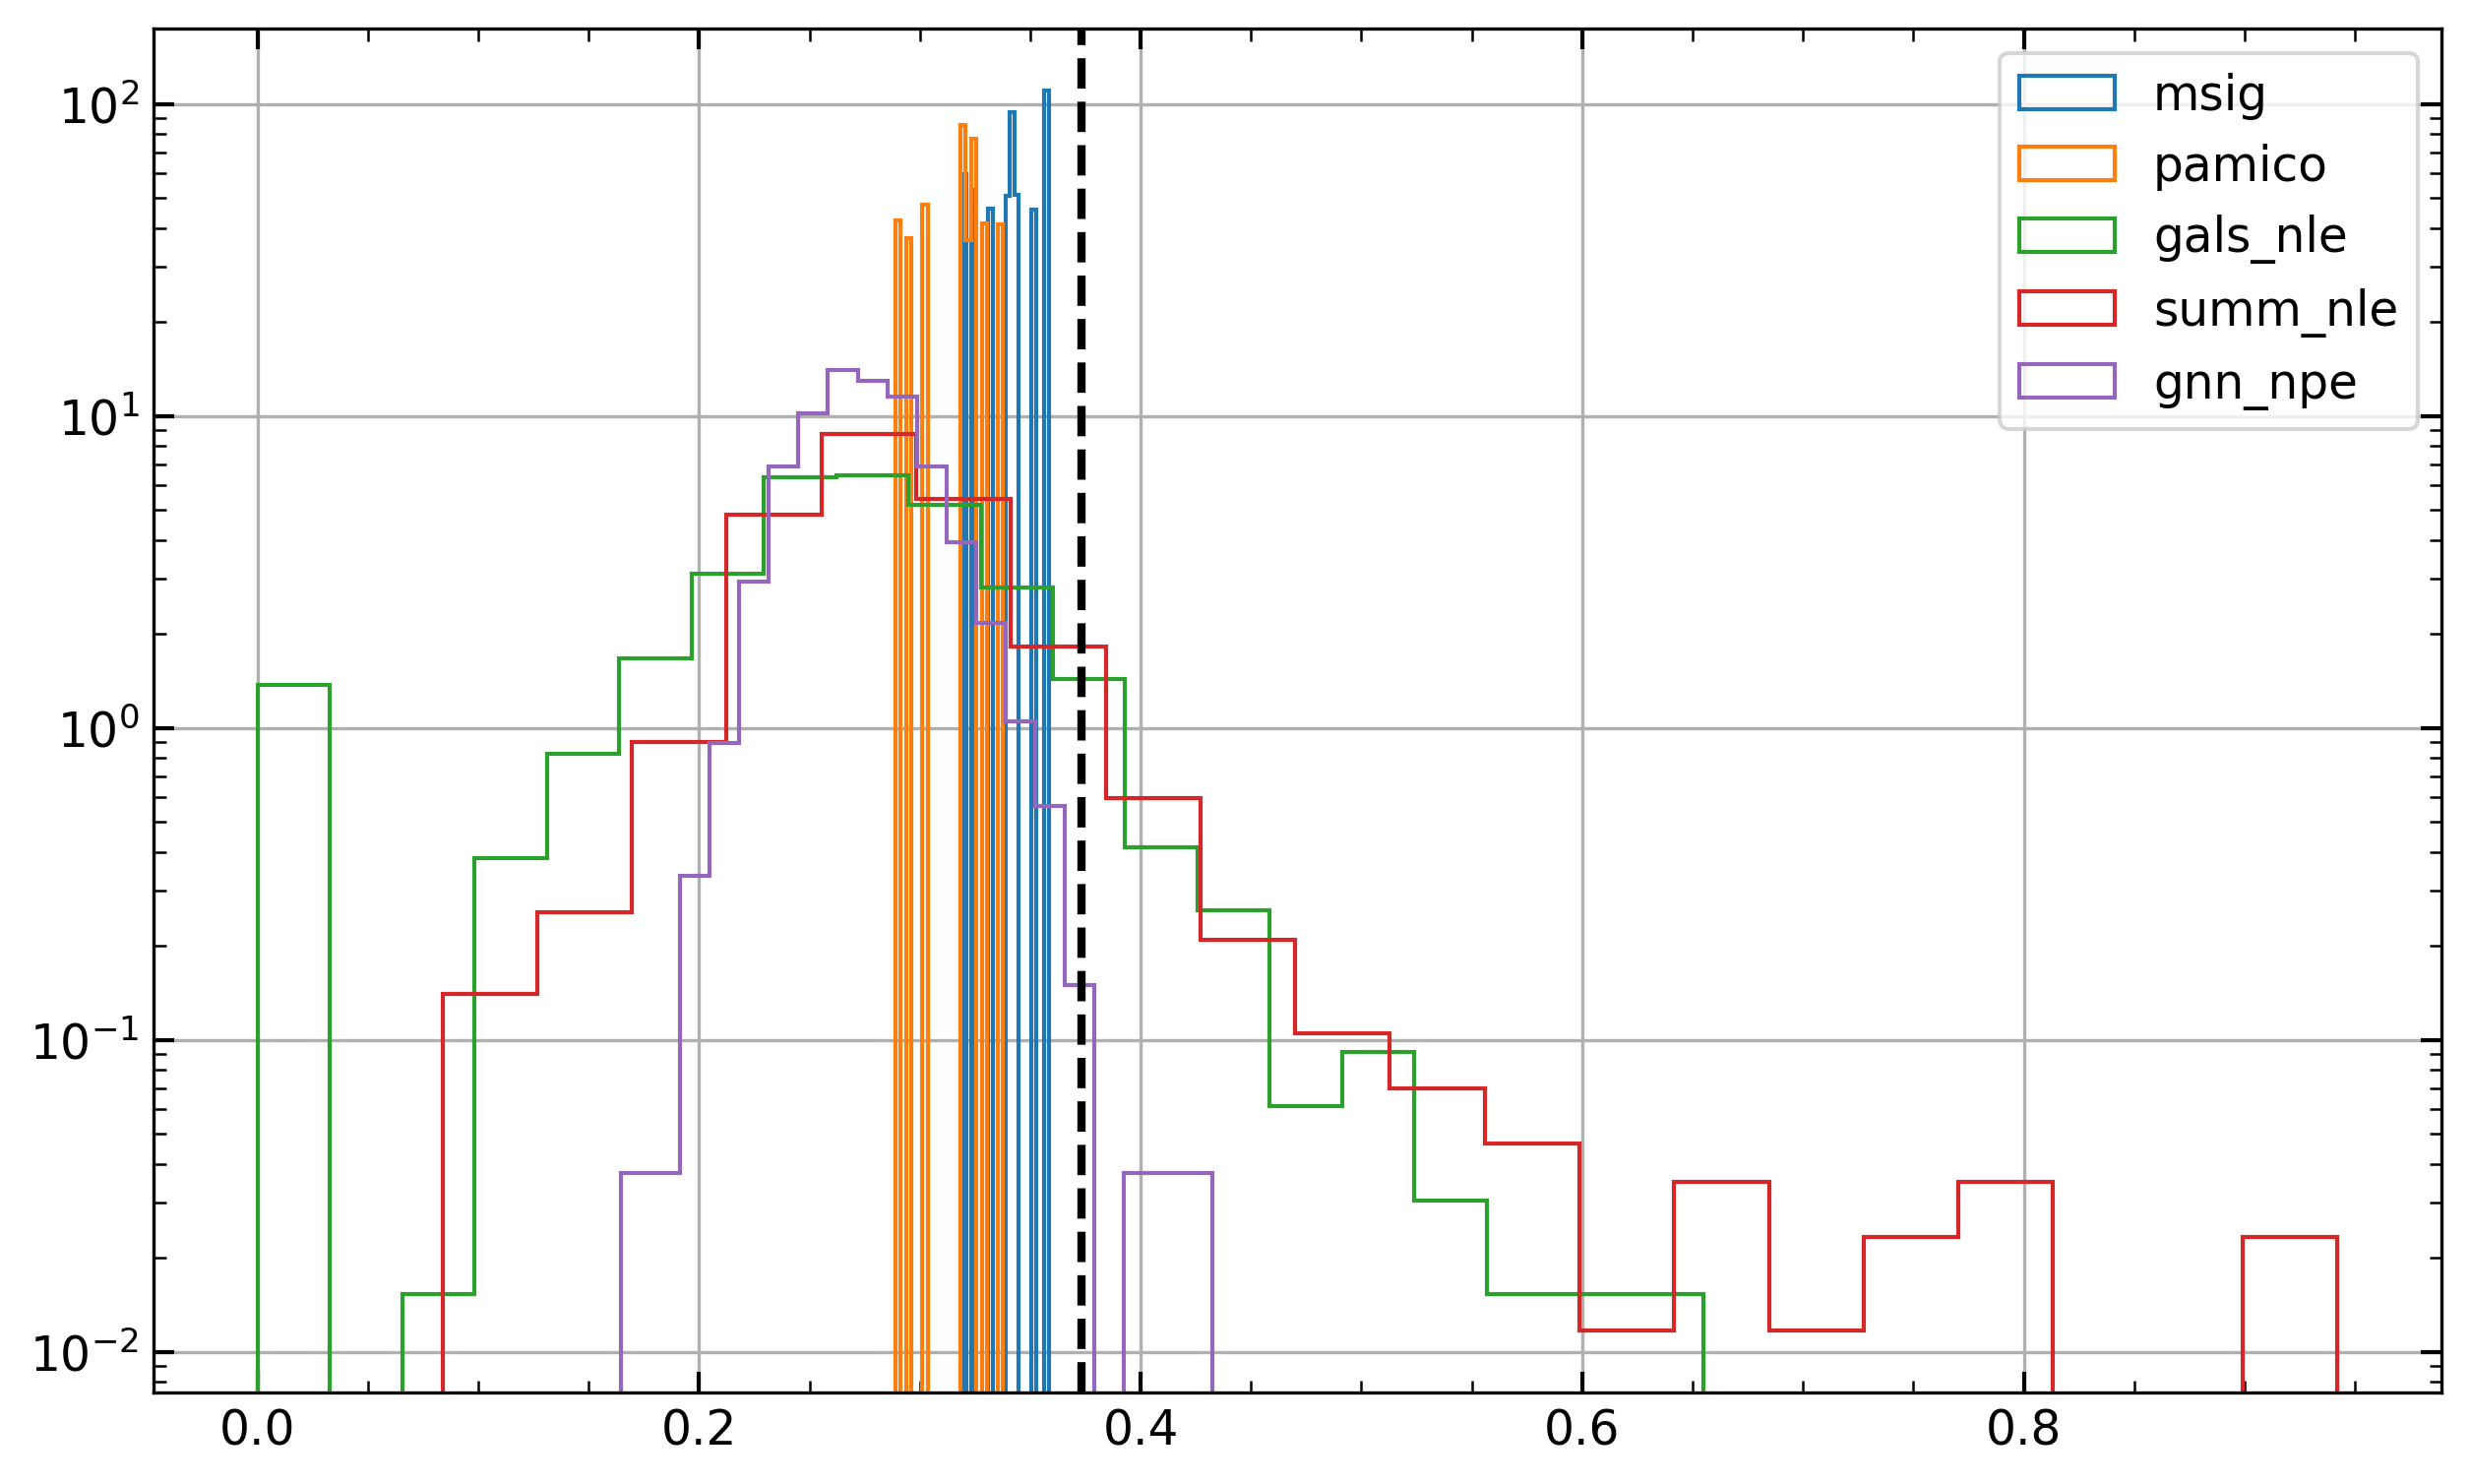

In [58]:
d = 'dC50'
for m in modelnames:
    if m not in percs[d]:
        print(m)
        continue
    _p = percs[d][m]
    plt.hist((_p[1]-_p[0])/2, label=m, bins=20, histtype='step', density=True)
plt.axvline(0.373, c='k', ls='--')
plt.semilogy()
plt.legend();

0.6882657845994857

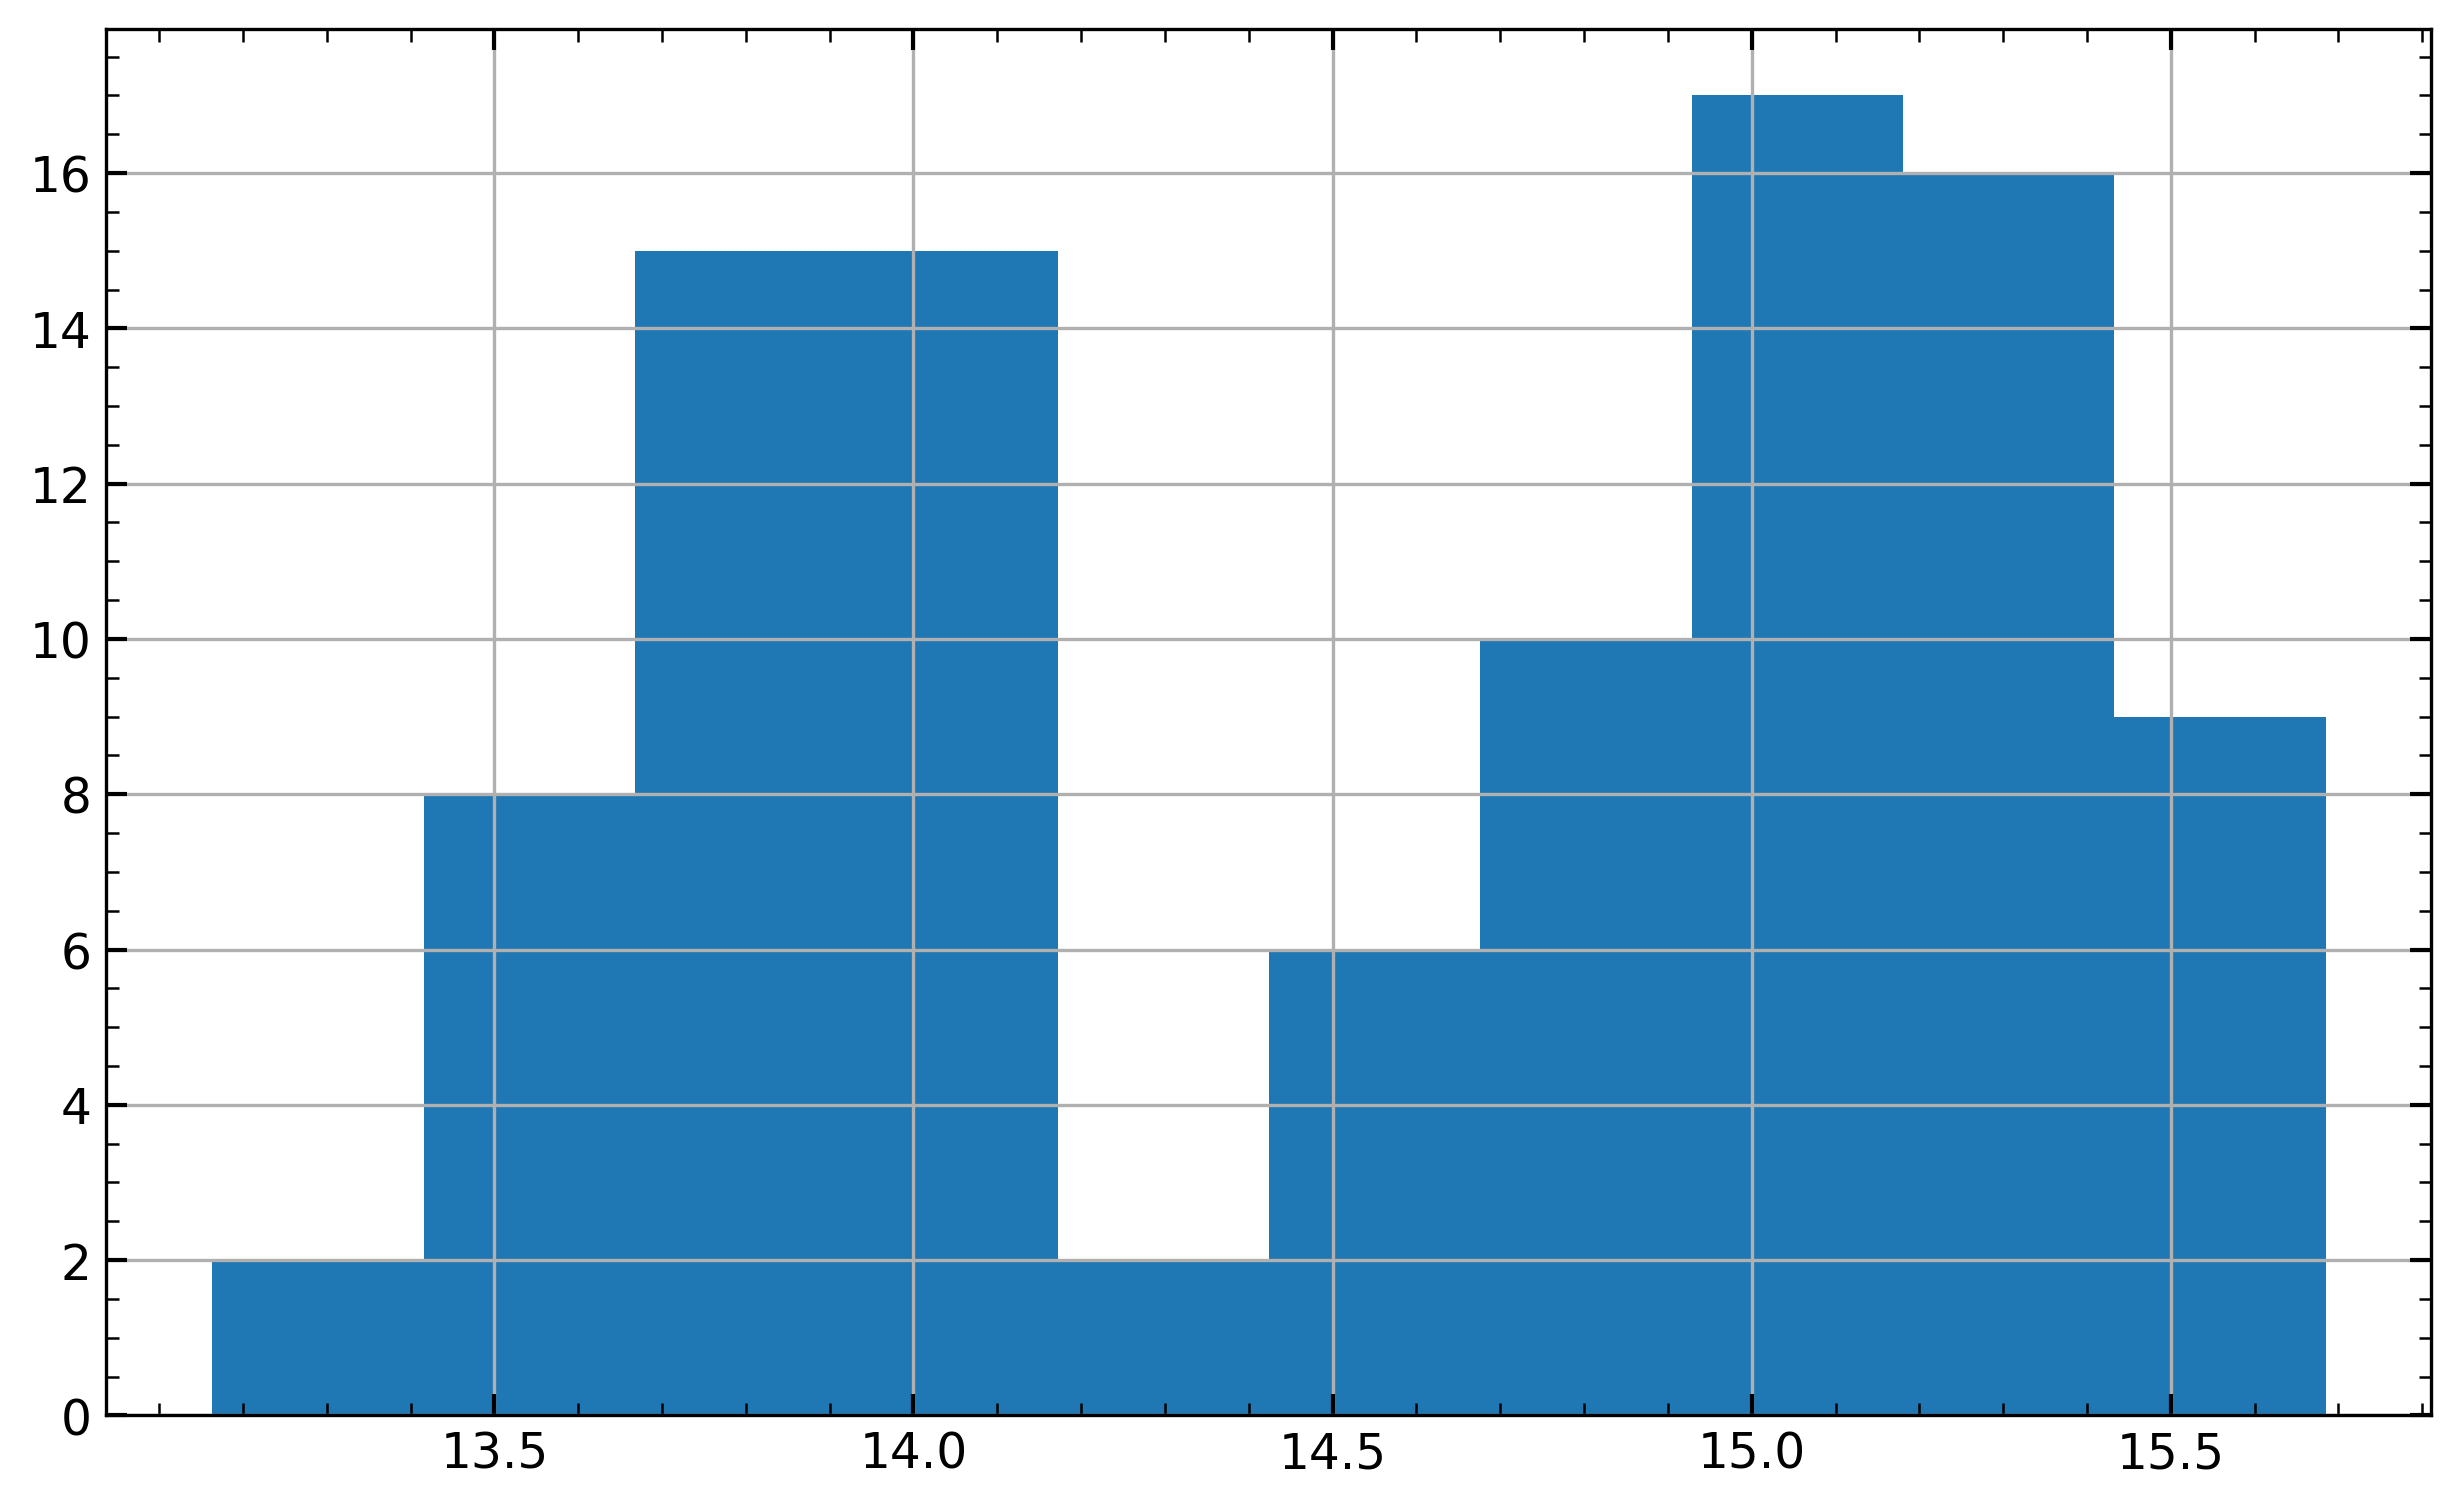

In [39]:
_p = preds['wC50']['summ_nle']
idx = np.argsort(_p.std(axis=1)[:,0])[-1]
plt.hist(_p[idx])
np.std(_p[idx])

mamp


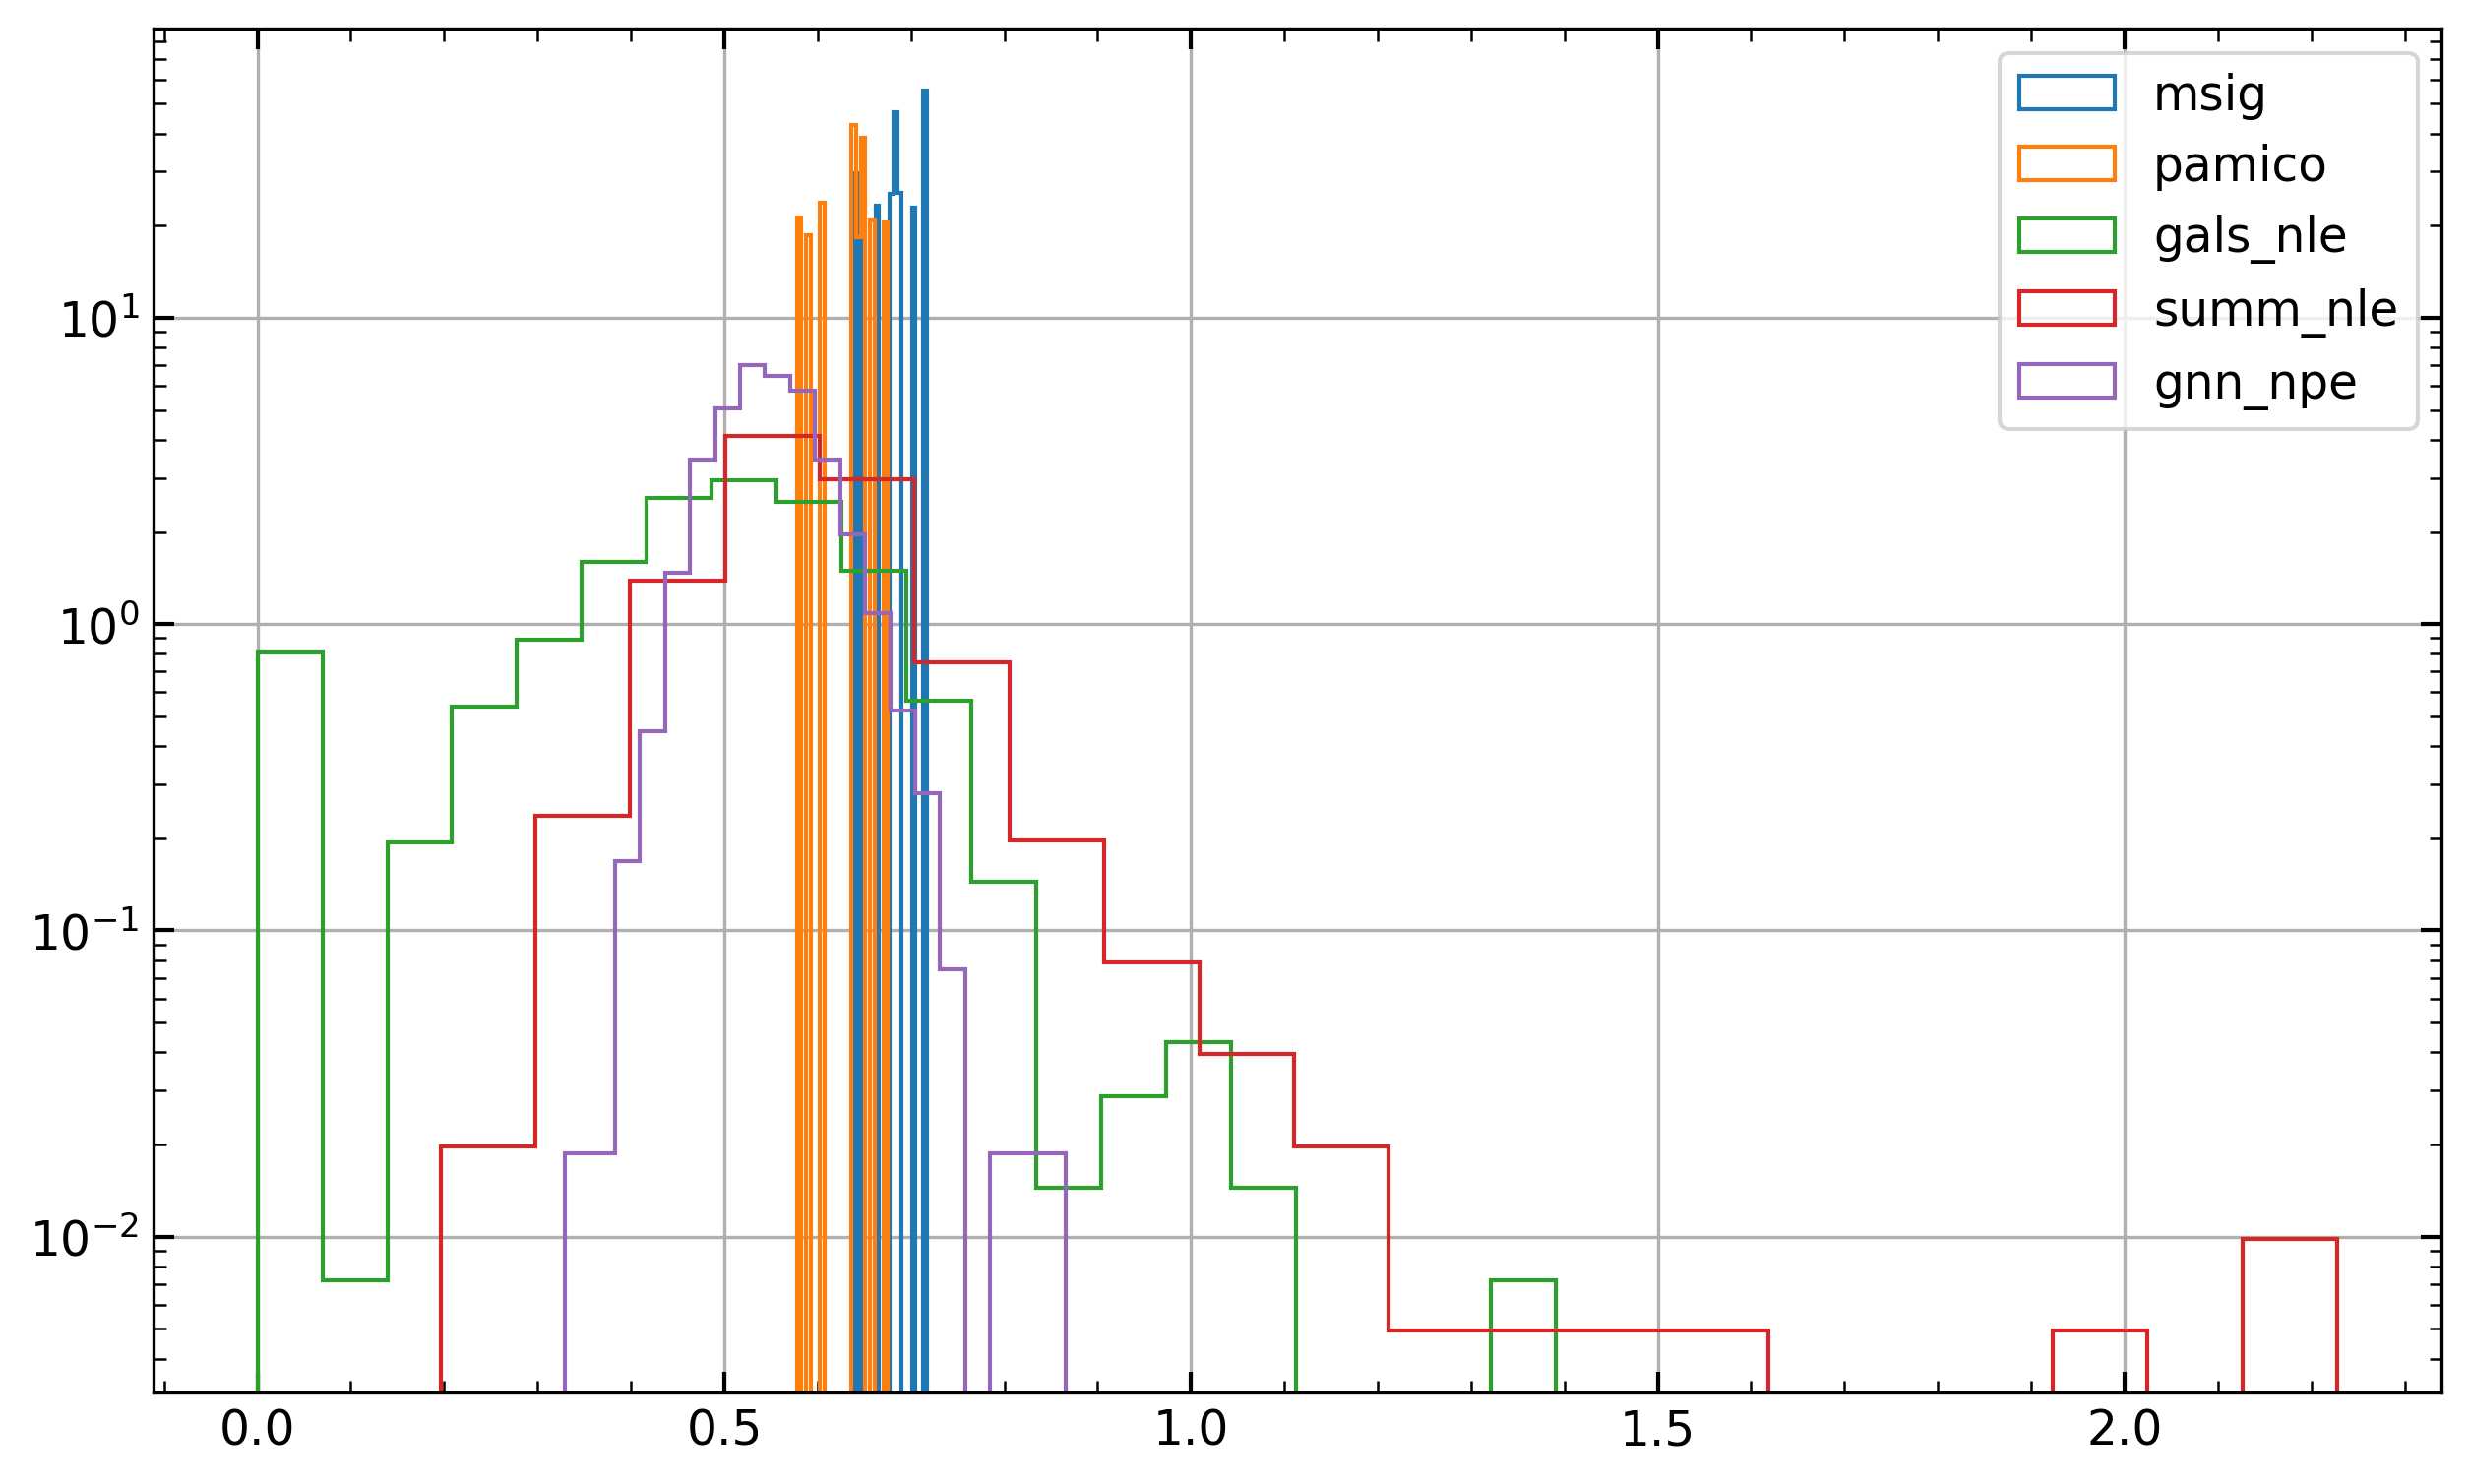

In [ ]:
d = 'dC50'
for m in modelnames:
    if m not in percs[d]:
        print(m)
        continue
    _p = percs[d][m]
    plt.hist(_p[1]-_p[0], label=m, bins=20, histtype='step', density=True)
plt.semilogy()
plt.legend();

## Scatter vs Richness, Redshift

# Coverage plots

# Scratch

## M-\lambda

In [13]:
filename = 'data/processed/APR24dC100/x_sum.npy'
x = np.load(filename, allow_pickle=True)
filename = 'data/processed/APR24dC100/theta_batch.npy'
theta = np.load(filename, allow_pickle=True)

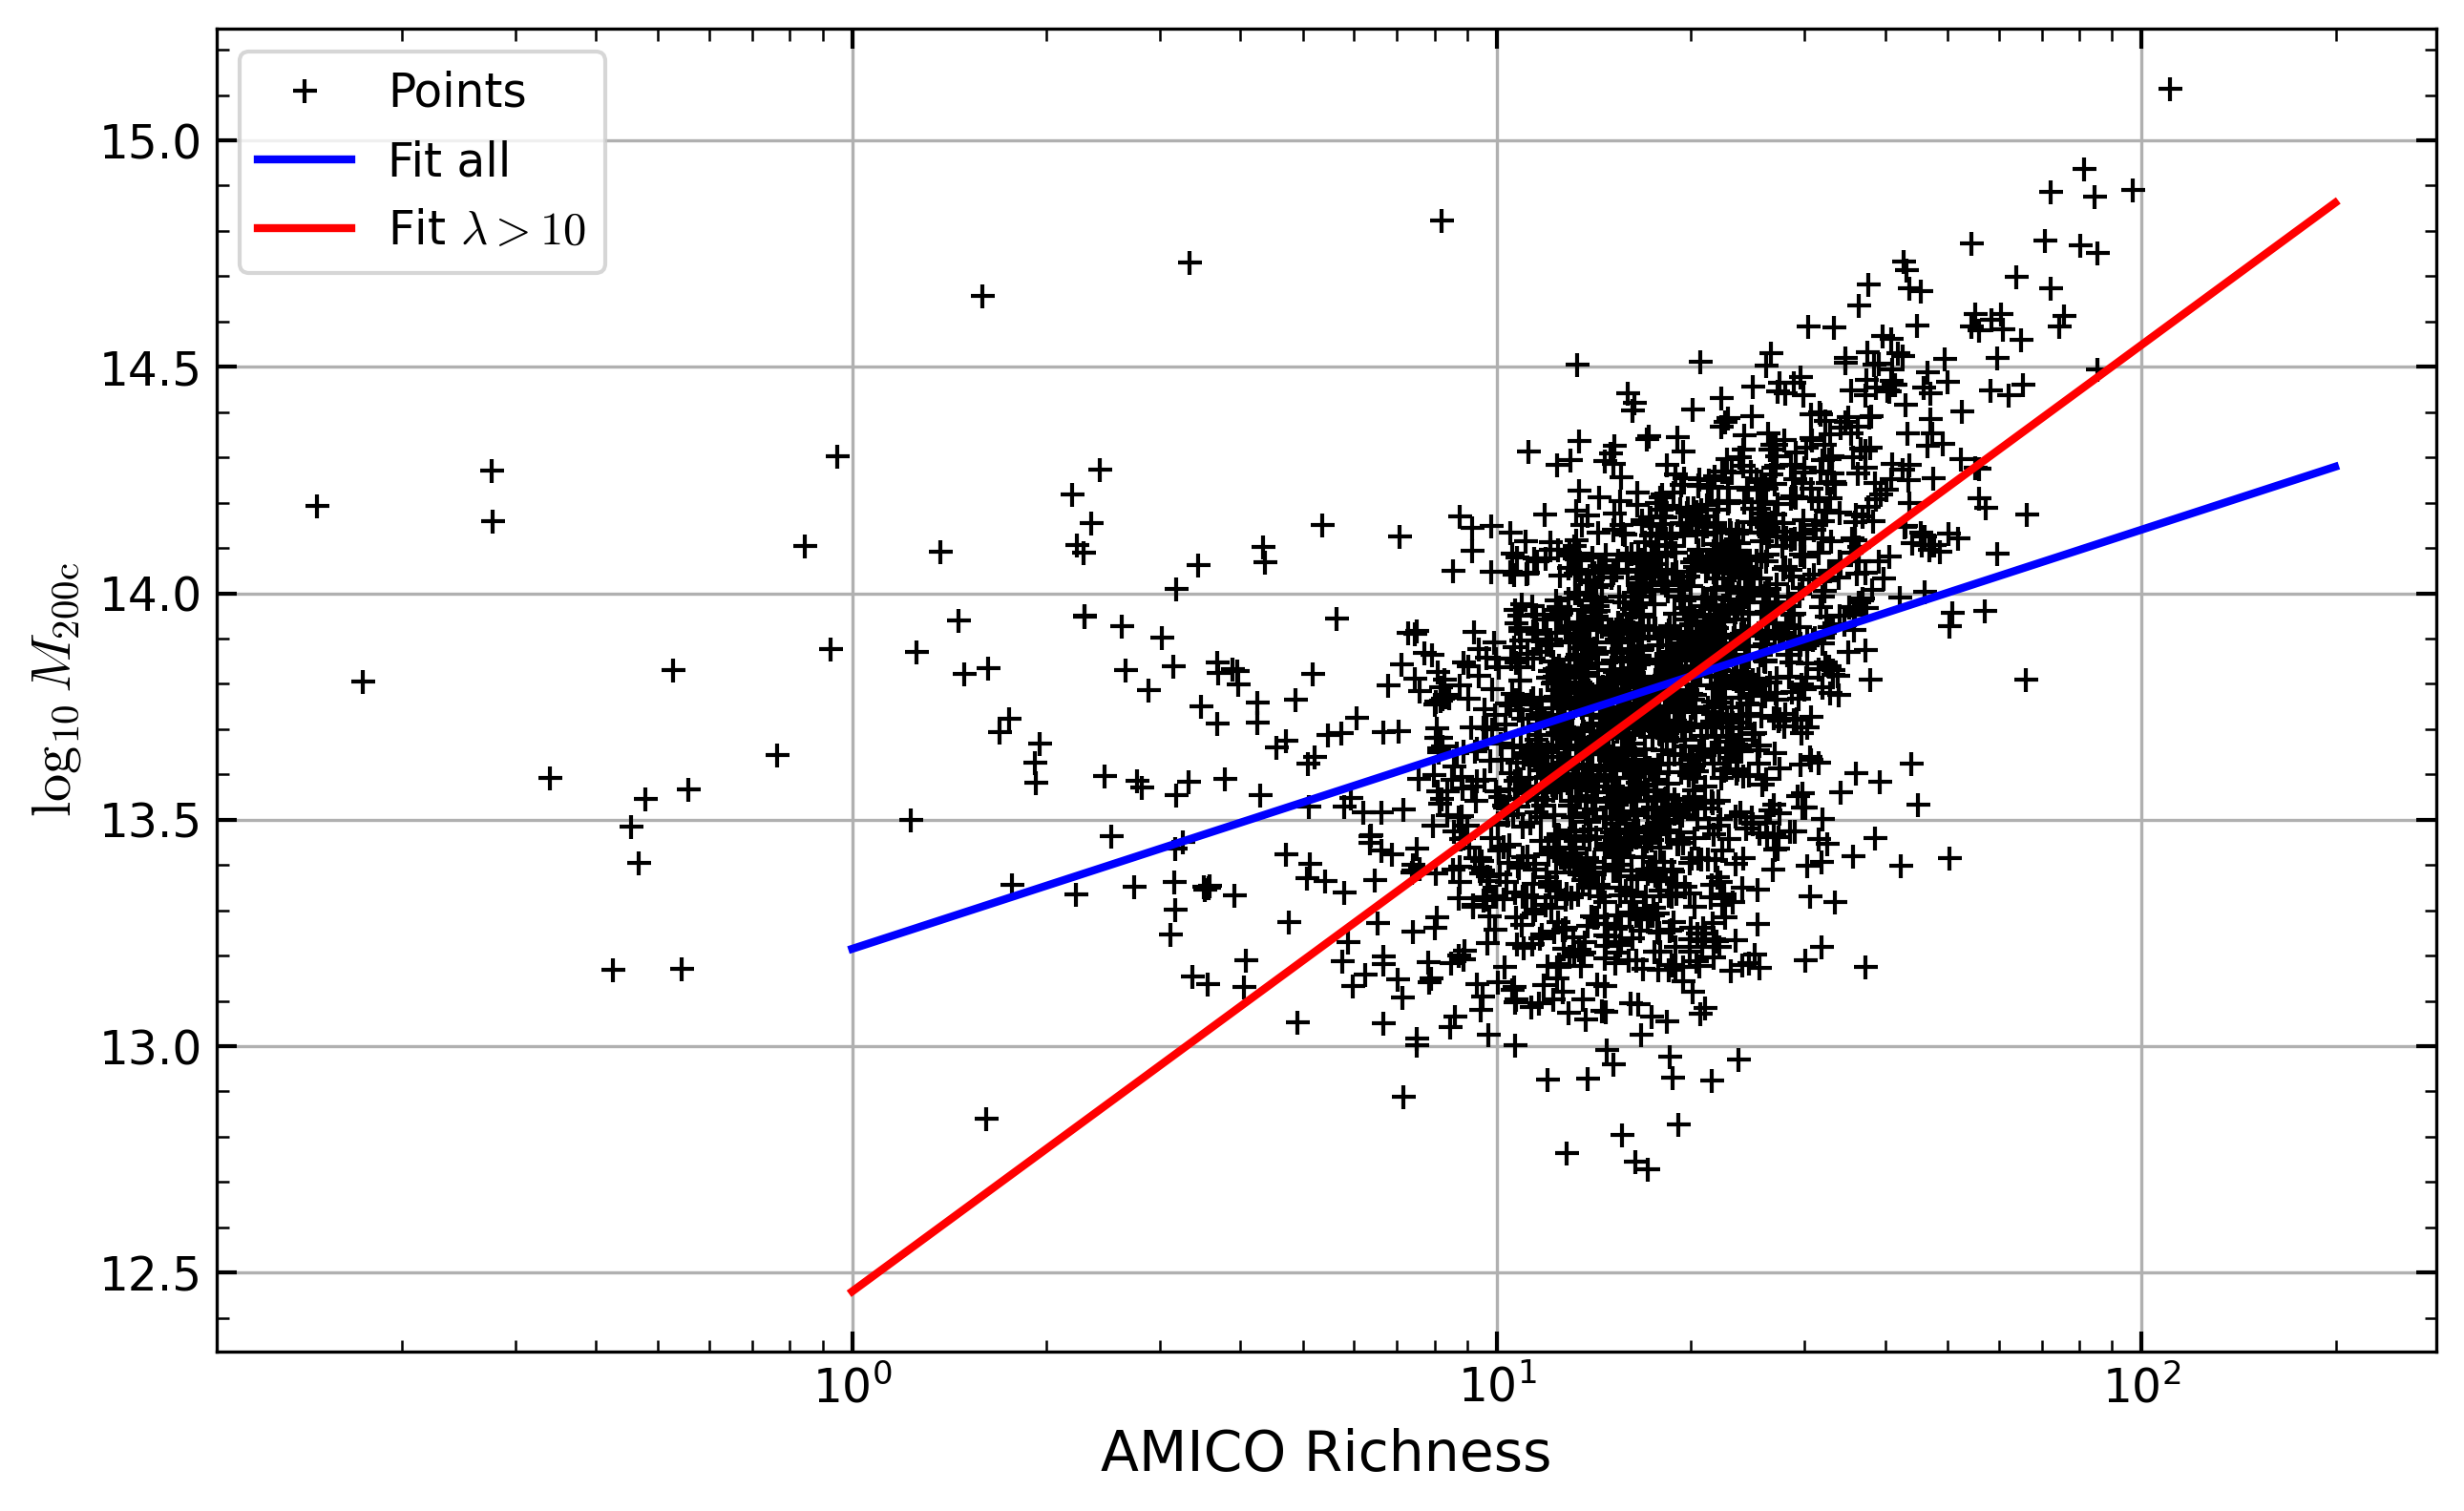

In [14]:
from sklearn.linear_model import LinearRegression


f, ax = plt.subplots()
ax.semilogx()
x_, y_ = x[:,3], theta
ax.plot(x_, y_, 'k+', label='Points')



x_, y_ = x[:,3], theta
mask = x_>0
reg = LinearRegression().fit(np.log10(x_[mask,None]), y_[mask])
x_ = np.linspace(0, 2.3, 100)[:,None]
y_ = reg.predict(x_)
ax.plot(10**x_, y_, 'b', label=r'Fit all')


x_, y_ = x[:,3], theta
mask = x_>10
reg = LinearRegression().fit(np.log10(x_[mask,None]), y_[mask])
x_ = np.linspace(0, 2.3, 100)[:,None]
y_ = reg.predict(x_)
ax.plot(10**x_, y_, 'r', label=r'Fit $\lambda>10$')

# ax.set_xlim(1)
ax.set_xlabel('AMICO Richness')
ax.set_ylabel(r'$\log_{10}M_{\rm 200c}$')
ax.legend()